# AI in industry <br/>
# Project

In [ ]:
# !pip install scikit-optimize
# !pip install xgboost lifelines

In [213]:
import xgboost as xgb
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib
import seaborn as sns
from tensorflow import keras
from keras.utils import to_categorical
from keras import layers, Model
from matplotlib import pyplot as plt
import pyarrow, copy
import sklearn as skl
from sklearn.utils import resample
from sklearn.svm import SVC
from functools import reduce
from skopt.space import Categorical, Real, Integer
from skopt.utils import use_named_args
from lifelines import KaplanMeierFitter
from skopt import gp_minimize
from skopt.plots import plot_convergence
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import keras.backend as K
import math,re

matplotlib.rcParams['figure.figsize'] = (6,5)
matplotlib.rcParams['axes.grid'] = False

import warnings
warnings.filterwarnings('ignore')

# High Performance Computing dataset

In [214]:
import os
# drive_path = '/content/drive/MyDrive'
# save_directory = os.path.join(drive_path, 'Saved_models')
# os.makedirs(save_directory, exist_ok=True)
# dataframe = pd.read_parquet(os.path.join(drive_path, 'job_table.parquet'))
path_data = '../data'
save_directory = os.path.join('.', 'Saved_models') #in notebook
os.makedirs(save_directory, exist_ok=True)
dataframe = pd.read_parquet(os.path.join(path_data, 'job_table.parquet'))

## Preprocessing

### Inspect and cleanup

Let's take an initial look at our data, taking into account that we will consider, for the target variable 'job state', just the values domain: **Time out**, **Failure**, **Out of memory** and **Completed**

In [215]:
class Initial_look:

  def __init__(self, data=dataframe):
    self.data = data.copy()
    _ = self.new_dataframe()

  def new_dataframe(self):
    self.data = self.data.loc[dataframe['job_state'].isin(c:=['COMPLETED', 'TIMEOUT', 'FAILED', 'OUT_OF_MEMORY'])]
    self.data['job_state'].cat.set_categories(c, inplace=True)
    self.data['year_month'].cat.as_ordered(inplace=True)

  def lookup(self):
    print('The shape of my dataset is {}'.format(d:=self.data.shape))
    stringg = str(list(self.data.dtypes))
    listt = zip(['Object', 'Categorical', 'Datetime'], [stringg.count(x) for x in ["('O')", 'Categorical', 'datetime']])
    print("We have {} features and are 'type distributed' in this way: \n {}".format(d[1],
                                                        '\n'.join(f'{x[0]} \t {x[1]}' for x in listt) ))
  def missing_values(self):
    self.data_1 = self.data.replace(to_replace='', value=None)
    catch_minor = lambda x: self.data_1[x].loc[self.data_1['year_month']<'20-11'].count()
    catch_major = lambda x: self.data_1[x].loc[self.data_1['year_month']>='20-11'].count()
    #instance.data_1['shared'].loc[instance.data_1['year_month']<'20-11'].count()
    print(pd.DataFrame(index = ['trackable required resources', 'exclusive job', 'ntasks per socket'],
          data=np.reshape([catch_major('tres_req_str'), catch_minor('tres_req_str'),
                           catch_major('shared'), catch_minor('shared'),
                           catch_major('ntasks_per_socket_str'), catch_minor('ntasks_per_socket_str')], (3,-1)),
          columns=['>=20-11', '<20-11']))
    return self.data.loc[self.data['year_month']<'20-11']


In [216]:
instance = Initial_look()

In [217]:
instance.lookup()

The shape of my dataset is (5711575, 100)
We have 100 features and are 'type distributed' in this way: 
 Object 	 91
Categorical 	 6
Datetime 	 3


A very important peculiarity: most of the object features have no data when we encounter the year_month 20-11, from this date forward: no data. Let's see the two approaches we can pursue: <br/>
1) To parse the dataset until the year_month 20-11 <br/>
2) Split the dataset in two parts, and perform two different analysis,   in the second dataset we are not going to exploit very important continuous feature. <br/>
For now we use the first approach.


Let's see data values that are in some feature that can be important.

In [218]:
dataframe_tmp = instance.missing_values()

                              >=20-11   <20-11
trackable required resources        0  1016530
exclusive job                       0  1016530
ntasks per socket                   0  1016530


All empty cells after the 19th November..no values

'Object' is a type data that can be tricky, since it can be anything (string, bytes, strings with integers...), I need to convert them in an appropriate data type, and throughout this process of conversion, it's necessary to comprehend completely the object feature we are analyzing



Thus, now we need to inspect each object feature, this can be time consuming but it's necessary. We want to encode them in order  they make sense and are useful for statistical purposes and are suitable for application of ML models.

Now, I've created a class allow me to bring order...the aim of this class is to 'clean' the dataframe. I've hardcoded the features I will drop, and with the execution of 'show_info' method, anyone can catch the reason behind the deletion. I have prefered the 'hardcoding' method and not the iteration between the features, because there are some exceptions, and the code would be so ugly, many if else conditions. <br/>


Some features that deserve a special mention: **dependency** and **nodes** (e tutte le features simili a questa). Sadly dependency has all empty cells, so we can state here that all jobs are independent, even if they are processed in the same machine (concurrent execution). Nodes feature tell me the names of nodes on which jobs are executed (info that I have at runtime not at start time).

In [219]:
class InitialClean:

  def __init__(self):
    self.dictionary = {'metadata': ['std_in','derived_ec', 'nodes', 'cpus_allocated', 'job_id', 'std_err', 'std_out', 'command', 'cpus_alloc_layout', 'work_dir', 'mem_per_node', 'mem_per_cpu', 'state_reason', 'exit_code', 'work_dir','name', 'tres_bind', 'alloc_sid', 'array_job_id', 'resv_name', 'comment','tres_per_node', 'bitflags', 'user_id', 'name', 'group_id', 'assoc_id', 'state_reason'] ,
                       'strange_domain': ['resize_time', 'max_nodes', 'sockets_per_node', 'ntasks_per_board', 'cpus_per_tres', 'sched_nodes', 'threads_per_core', 'req_nodes', 'ntasks_per_core', 'wckey', 'pn_min_tmp_disk', 'metric', 'array_task_throttle', 'min_memory_node', 'tres_per_job', 'suspend_time', 'profile', 'sockets_per_board', 'reboot', 'cpus_per_tres', 'power_flags', 'features', 'min_memory_cpu', 'batch_flag', 'plugin', 'requeue', 'max_cpus', 'restart_cnt', 'boards_per_node', 'time_min', 'show_flags', 'wait4switch'],
                       'missing_values': ['tres_freq', 'dependency', 'array_task_str', 'cores_per_socket', 'tres_per_socket', 'tres_per_task', 'array_max_tasks', 'exc_nodes', 'req_switch', 'array_task_id'],
                       'redundant':['ntasks_per_socket', 'accrue_time', 'batch_host', 'alloc_node','min_memory_node','time_limit_str' ],
                       'posterior': ['run_time_str', 'end_time', 'state_reason', 'run_time']}
    self.keys = self.dictionary.keys()
    self.values = self.dictionary.values()

  def clean(self, x):
    if set(self.dictionary['posterior']).issubset(x.columns):
      x = x.drop(columns=list(sum(self.values, [])))
      return x
    else: return x

  def __repr__(self):
    return '\n'.join(map(lambda x: x + ':\t' + ', '.join('\n\t\t'+ z if (y%8)==0 else z for y,z in enumerate(self.dictionary[x])), self.keys))

  def show_info(self, name_column, dataframe):
    if not isinstance(dataframe, pd.DataFrame):
      raise ValueError(f'I wanna a dataframe not a {type(dataframe)}')
    self.callable = {'missing_values': self.missing_values, 'redundant': self.redundant, 'metadata': self.metadata, 'strange_domain':self.strange_domain, 'posterior':self.posterior}
    self.x = [x for x in self.keys if name_column in self.dictionary[x]]
    return self.callable[self.x[0]](dataframe, name_column) if self.x else "It's not in my dictionary"

  def strange_domain(self,x, name_column):
    self.series = x[name_column]
    unique = pd.unique(self.series)
    return pd.Series(index=unique, data=[self.series.loc[self.series==value].shape[0] for value in unique])

  def missing_values(self, x, name_column):
    self.series = x[name_column]
    return 'There are {} missing values'.format(self.series.loc[self.series==''].shape[0])

  def metadata(self, x, name_column):
    self.series = x[name_column]
    return pd.unique(self.series)

  def redundant(self, x, name_column):
    redundant={'ntasks_per_socket':'ntasks_per_socket_str', 'accrue_time':'submit_time', 'batch_host': ['nodes', 'Only one node per job, even if multiple nodes are allocated'], 'alloc_node': ['nodes', 'Only one node per job, even if multiple nodes are allocated'], 'min_memory_node':['tres_req_str', 'Reduntant + missing values'], 'time_limit_str':'time_limit'}
    feature, reason = c if isinstance(c:=redundant[name_column], list) else [c,None]
    print('{} is redundant since it gives same infos of this feature {}'.format(name_column, feature) + (f'and moreover {reason}' if reason else '') + '\n')
    return x[[name_column, feature]].head(15)

  def posterior(self, x, name_column):
    return 'This infos are catched after the start_time of the job, so not useful for this analysis'



In [220]:
InitialClean()

metadata:	
		std_in, derived_ec, nodes, cpus_allocated, job_id, std_err, std_out, command, 
		cpus_alloc_layout, work_dir, mem_per_node, mem_per_cpu, state_reason, exit_code, work_dir, name, 
		tres_bind, alloc_sid, array_job_id, resv_name, comment, tres_per_node, bitflags, user_id, 
		name, group_id, assoc_id, state_reason
strange_domain:	
		resize_time, max_nodes, sockets_per_node, ntasks_per_board, cpus_per_tres, sched_nodes, threads_per_core, req_nodes, 
		ntasks_per_core, wckey, pn_min_tmp_disk, metric, array_task_throttle, min_memory_node, tres_per_job, suspend_time, 
		profile, sockets_per_board, reboot, cpus_per_tres, power_flags, features, min_memory_cpu, batch_flag, 
		plugin, requeue, max_cpus, restart_cnt, boards_per_node, time_min, show_flags, wait4switch
missing_values:	
		tres_freq, dependency, array_task_str, cores_per_socket, tres_per_socket, tres_per_task, array_max_tasks, exc_nodes, 
		req_switch, array_task_id
redundant:	
		ntasks_per_socket, accrue_time, batch_host

In [221]:
dataframe_tmp_1 = InitialClean().clean(dataframe_tmp)

### Feature engineering

In [222]:
def try_this(x,string:str):
  try: x()
  except Exception as e:
    return string

Many features need to be encoded, let's see them

A possible issue is the value 'UNLIMITED' available in the domain of **ntasks_per_socket_str**... from an analytical point of view it has no meaning, so I decide to discretize this feature in two different range: [LIMITED, UNLIMITED], two bins of equal numerosity...I know doing that i lose in granularity and resolution, but encode 'UNLIMITED' as an outlier would be no good for the distribution of this variable, since 'UNLIMITED' is too frequent...The domain distribution is highly  polarized towards two values: '2' and 'Unlimited'

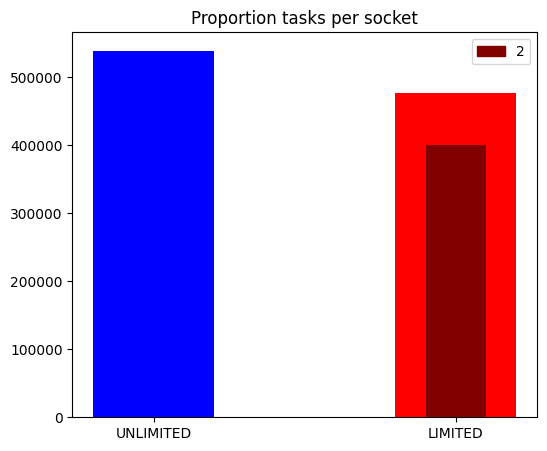

In [223]:
if 'UNLIMITED' in pd.unique(dataframe_tmp_1['ntasks_per_socket_str']):
  dataframe_tmp_1.loc[dataframe_tmp_1['ntasks_per_socket_str']!='UNLIMITED', 'ntasks_per_socket_str']= 1.
  dataframe_tmp_1.loc[dataframe_tmp_1['ntasks_per_socket_str']=='UNLIMITED', 'ntasks_per_socket_str']= 0.
  dataframe_tmp_1.loc[dataframe_tmp_1['ntasks_per_core_str']=='UNLIMITED', 'ntasks_per_core_str']= 0.

plt.bar(x=['UNLIMITED', 'LIMITED'], height=dataframe_tmp_1['ntasks_per_socket_str'].value_counts(), width=0.4, color=['blue', 'red'])
plt.bar(x=['LIMITED'], height=dataframe_tmp['ntasks_per_socket_str'].loc[dataframe_tmp['ntasks_per_socket_str']=='2'].shape[0], color='maroon', width=0.2)
maroon_patch = matplotlib.patches.Patch(color='maroon', label='2')
plt.legend(handles=[maroon_patch])
plt.title('Proportion tasks per socket')
plt.show()

In [224]:
dataframe_tmp_1.loc[(dataframe_tmp_1['shared']=='OK') | (dataframe_tmp['shared']=='USER'), 'shared']= 1.
dataframe_tmp_1.loc[dataframe_tmp_1['shared']=='0', 'shared']= 0.
dataframe_tmp_1.loc[dataframe_tmp_1['contiguous']=='True', 'contiguous']= 1.
dataframe_tmp_1.loc[dataframe_tmp_1['contiguous']=='False', 'contiguous']= 0.

Now we need to encode these two features: **tres_alloc_req**, **tres_req_str**

In [225]:
print(dataframe_tmp_1[['tres_alloc_str', 'tres_req_str']])

                                            tres_alloc_str  \
0                       cpu=4,mem=246000M,node=1,billing=4   
1                       cpu=4,mem=246000M,node=1,billing=4   
3                       cpu=4,mem=246000M,node=1,billing=4   
4                                                            
5                       cpu=4,mem=246000M,node=1,billing=4   
...                                                    ...   
1074571        cpu=4,mem=8000M,node=1,billing=4,gres/gpu=1   
1074572  cpu=128,mem=237.50G,node=1,billing=128,gres/gpu=4   
1074573  cpu=128,mem=230000M,node=1,billing=128,gres/gpu=4   
1074574        cpu=8,mem=7100M,node=1,billing=8,gres/gpu=1   
1074575        cpu=4,mem=8000M,node=1,billing=4,gres/gpu=1   

                                              tres_req_str  
0                       cpu=4,mem=246000M,node=1,billing=4  
1                       cpu=4,mem=246000M,node=1,billing=4  
3                       cpu=4,mem=246000M,node=1,billing=4  
4        cp

In theory  in tres_alloc_str feature: **cpus**, **node** and **billing** corresponds to the values in the feature num_cpus, num_nodes and billable_tres...we verify immediately. Moreover **num_cpus** and **num_nodes** features has no missing values

In [226]:
def check_equality(node=dataframe_tmp_1['num_nodes'], cpu=dataframe_tmp_1['num_cpus'], billing=dataframe_tmp_1['billable_tres']):
  pattern_cpu = re.compile('(?<=u=)\d+')
  pattern_node = re.compile('(?<=e=)\d+')
  pattern_billing = re.compile('(?<=g=)\d+')
  index_missing = dataframe_tmp_1['tres_alloc_str']==''
  cpu_tres = (d:=dataframe_tmp_1['tres_alloc_str'][~index_missing]).map(lambda x: pattern_cpu.search(x).group())
  node_tres = d.map(lambda x: pattern_node.search(x).group())
  billing_tres = d.map(lambda x: pattern_billing.search(x).group())
  listt = [cpu[~index_missing], node[~index_missing], billing[~index_missing].map(lambda x: re.search('\d+', x).group())] # some inputs had decimal .0
  return all([(listt[y]==x).all() for y,x in enumerate([cpu_tres, node_tres, billing_tres])])


In [227]:
print(f' The equality has been confirmed: {check_equality()}')

 The equality has been confirmed: True


Now I wanna 7 columns, they are the encoding of tres_alloc_str and tres_req_str: (Ps. we have already billing, cpu and node allocated): <br/>
- gpu <br/>
- num_mem (in Gb)<br/>
- num_mem_req (in Gb)<br/>
- billing_tres_req <br/>
- num_cpus_req <br/>
- num_nodes_req <br/>
- gpu_req

In [228]:
class Encoding:

  def __init__(self, data=dataframe_tmp_1):
    self.data = data
    self.pattern = re.compile('[\.\dM]+')
    self.pattern_1 = re.compile('(?<=gpu=)\d+')
    self.pattern_2 = re.compile('(?<=m=)[\.\dM]+')

  def new_columns(self):
    if 'tres_req_str' in self.data.columns:
      self.new_columns = ['num_cpus_req', 'num_mem_req', 'num_nodes_req', 'billing_tres_req', 'gpu_req' ,'num_mem_alloc', 'gpu_alloc']
      for y,x in enumerate([pd.Series(index=self.data.index, data=x) for x in self.req()] + list(self.alloc())):
        self.data[self.new_columns[y]] = x
      self.data = self.data.drop(columns=['tres_req_str', 'tres_alloc_str'])
      return self.data
    else: return self.data

  def req(self):
    self.dataframe = self.data['tres_req_str'].map(lambda x: l if len(l:=self.pattern.findall(x))==5 else l+['0'])
    self.array = np.array(self.dataframe.tolist())
    self.num_cpus_req, self.num_mem_req, self.num_nodes_req, self.billing_tres_req, self.gpu_req =  [self.array[:,x] for x in range(5)]
    self.num_mem_req = np.vectorize(lambda x: float(x[:-1])/10**3 if 'M' in x else float(x))(self.num_mem_req)
    return self.num_cpus_req, self.num_mem_req, self.num_nodes_req, self.billing_tres_req, self.gpu_req

  def alloc(self):
    self.num_mem_alloc = self.data['tres_alloc_str'].map(lambda x: s.group() if (s:=self.pattern_2.search(x)) else s)
    self.num_mem_alloc[~self.num_mem_alloc.isnull()] = self.num_mem_alloc[~self.num_mem_alloc.isnull()].map(lambda x: float(x[:-1])/10**3 if 'M' in x else float(x))
    self.gpu_alloc = self.data['tres_alloc_str'].map(lambda x: s.group() if (s:=self.pattern_1.search(x)) else ('0' if x else s))
    return self.num_mem_alloc, self.gpu_alloc


In [229]:
dataframe_tmp_1 = Encoding().new_columns()

### Statistical analysis
Now we have an issue to deal with: the time. We know we need to discretize it in order that it can be useful for the analysis. We have more variables that have as domain the time 'eligible_time, last_sched_eval, start_time, submit_time'. My initial idea is encode the time in this way: <br/>
1) Show the time distribution is not uniform <br/>
2) Compute the proportion of the 4 classes in the dataset, we can spot a unit of time that can provide more insights...where the proportion is not the same..changes. <br/>
The time variable considered is the *submit-time*, for the moment the other ones will be encoded in seconds or minutes (depends on the range, if too large, i will consider minutes)...the seconds/minutes passed by the starting time. <br/>

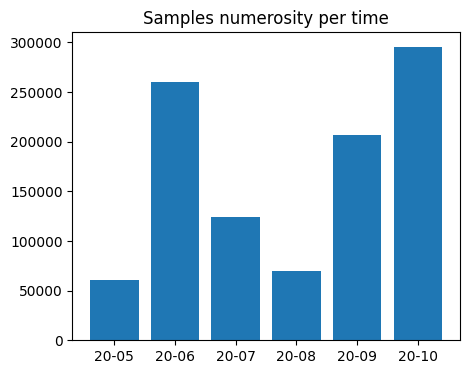

In [230]:
# is quite evident..i don t need a statistical test
d=dataframe_tmp_1['year_month'].value_counts().sort_index()
plt.figure(figsize=(5,4))
plt.bar(x=d.index[d!=0], height=d[d!=0])
plt.title('Samples numerosity per time')
plt.show()

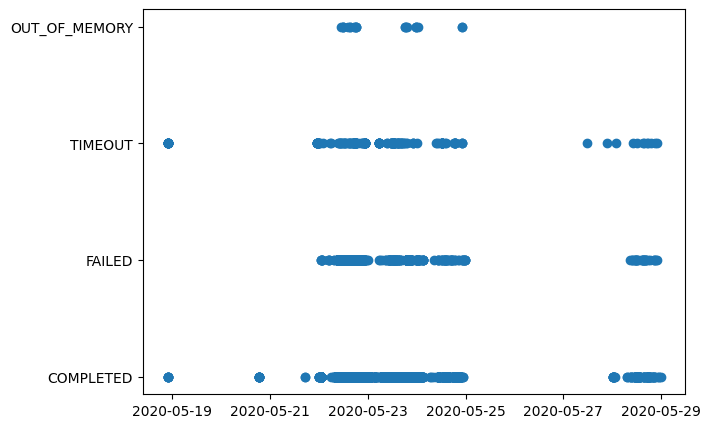

In [231]:
plt.figure(figsize=(7,5))
uu=plt.scatter(dataframe_tmp_1['submit_time'].values[:10000], dataframe_tmp_1['job_state'].values[:10000])

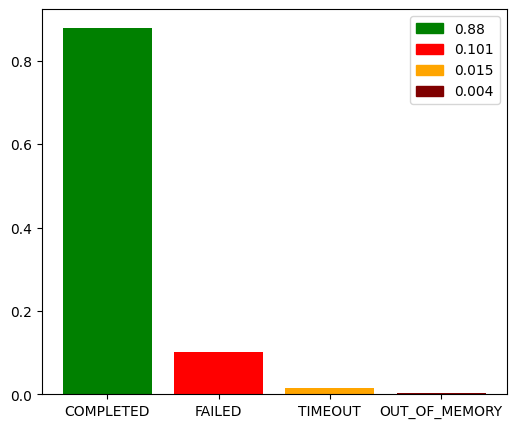

In [232]:
# now inspect the proportion in entire dataset and then for each time unit granularity (hours, day, week, month)
d=dataframe_tmp['job_state'].value_counts()
plt.figure(figsize=(6,5))
color = ['green', 'red', 'orange','maroon']
plt.bar(x = d.index, height=d.map(lambda x: x/d.sum()), color=color)
patches = list(map(lambda x: matplotlib.patches.Patch(color=x[0], label=round(x[1]/d.sum(), 3)), zip(color, d)))
plt.legend(handles = patches)
plt.show()

The dataset is very imbalanced w.r.t to the job exit state classes

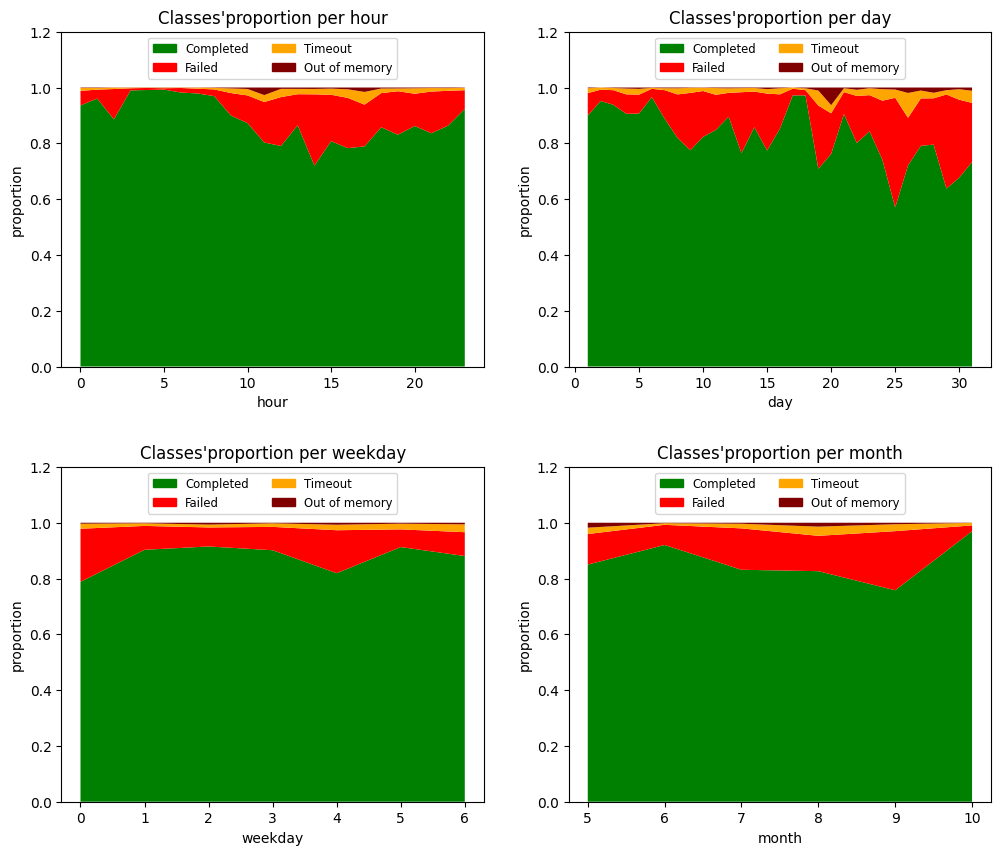

In [233]:
class plot_time:
  def __init__(self, x, data=dataframe_tmp_1):
    self.data_plotting = data[['job_state', 'submit_time', 'account']].copy()
    self.time_dictionary = {'minute': self.data_plotting['submit_time'].dt.minute, 'hour': self.data_plotting['submit_time'].dt.hour,
                       'day': self.data_plotting['submit_time'].dt.day, 'weekday': self.data_plotting['submit_time'].dt.weekday,
                       'month': self.data_plotting['submit_time'].dt.month, 'year': self.data_plotting['submit_time'].dt.year}
    self.x = x
    self.size = np.array(x).reshape(-1,2).shape[0]

  def plot(self):
    plt.figure(figsize=(12,10))
    self.time, self.sum, self.d = {}, {}, {}
    for i in range(len(self.x)):
      actual_time = self.x[i]
      time_max, time_min = (c:=self.time_dictionary[actual_time]).max() + 1, c.min()
      self.time[actual_time] = range(time_min, time_max)
      self.data_plotting[actual_time] = c
      self.d[actual_time] = self.data_plotting.groupby([actual_time, 'job_state'])['job_state'].count().unstack()
      self.sum[actual_time] = self.d[actual_time].sum(axis=1)
      d_norm = self.d[actual_time].div(self.sum[actual_time], axis=0)
      plt.subplot(self.size, 2, i+1)
      plt.stackplot(self.time[actual_time], d_norm.COMPLETED.to_numpy(), d_norm.FAILED.to_numpy(), d_norm.TIMEOUT.to_numpy(), d_norm.OUT_OF_MEMORY.to_numpy(), colors=color)
      plt.subplots_adjust(hspace = 0.3, wspace=0.2)
      patches = list(map(lambda x: matplotlib.patches.Patch(color=x[0], label=x[1]), zip(color, ['Completed', 'Failed', 'Timeout', 'Out of memory'])))
      plt.ylim(0., 1.2)
      plt.ylabel('proportion')
      plt.xlabel(f'{actual_time}')
      plt.legend(handles=patches, fontsize='small', ncol=2, loc='upper center')
      plt.title(f"Classes'proportion per {actual_time}")

  def variability_per_time(self, time, type_job='FAILED'):
    self.dictionary = {'year': 'Y', 'month': 'M', 'weekday': 'W', 'day':'D','hour': 'H', 'minute': 'T'}
    self.series = pd.Series(index=self.data_plotting['submit_time'].values, data=self.data_plotting['job_state'].values)
    self.series = pd.get_dummies(data=self.series).resample(self.dictionary[time]).sum() # resample by time (with sum)
    self.dictionary = {'year': self.series.index.year, 'month': self.series.index.month,
                       'weekday': self.series.index.weekday, 'day':self.series.index.day,
                       'hour': self.series.index.hour, 'minute': self.series.index.minute }
    sns.catplot(x=self.dictionary[time], y=self.series[type_job], jitter=False, height=5, aspect=1.60)
    plt.ylabel('Numerosity_'+ type_job.lower())
    plt.xlabel(f'{time}s')
    plt.title(f'Variability per {time}s')
    plt.tight_layout()
    plt.show()


  def insight(self, time, series=None, type_job='FAILED'):
    if series:
      pd.Series(index=self.time[time], data=self.sum[time]).plot()
      plt.title('Total Numerosity')
      plt.xlabel(f'{time}')
      plt.ylabel('N')
      plt.show()
    else:
      p = pd.unique(self.data_plotting['account'])
      self.d = {p[x]:x for x in range(len(p))}
      self.data_plotting['account']= self.data_plotting['account'].map(self.d)
      self.data_plotting_2 = self.data_plotting.loc[self.data_plotting['job_state']==type_job]
      plt.hist2d(x=self.data_plotting_2['account'], y=self.data_plotting_2[time], bins=[50,len(self.time[time])])
      plt.ylabel(f'{time}')
      plt.xlabel('User account')
      plt.title('Locality user w.r.t ' + type_job.lower())
      plt.colorbar()


e = plot_time(['hour', 'day', 'weekday', 'month'])
e.plot()

**Hour plot** (failed jobs section)<br/>
Viewing the hour plot, one consideration could be: in the working hours (10-17), we expect more jobs, so the failure numerosity increase faster than jobs numerosity. But this thesis can be immediately denied: <br/> - let's take a look at the variability per hour: nelle ore notturne, abbiamo una situazione stabile, poca variabilità (eccezione le 2), e tutto è riscontrabile nel plot delle proporzioni. Invece nelle ore diurne e alla sera, abbiamo maggiore variabilta nella distribuzione delle osservazioni (anche la media incrementa): quindi piu o meno la situazione dovrebbe essere simile nel nostro plot precedente... tranne il picco negativo in corrispondenza delle ore 14: tale picco puo essere spiegato con il fatto che le osservazioni anomale hanno piu effetto dal momento che la numerosità totale in quell ora è piu bassa.

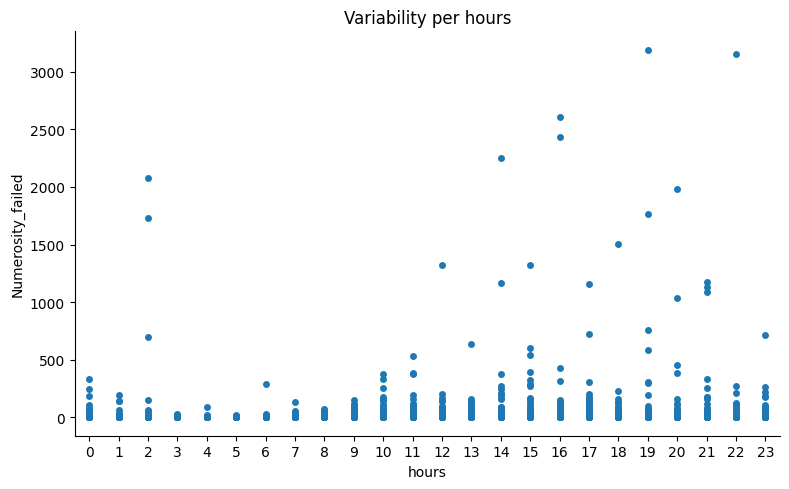

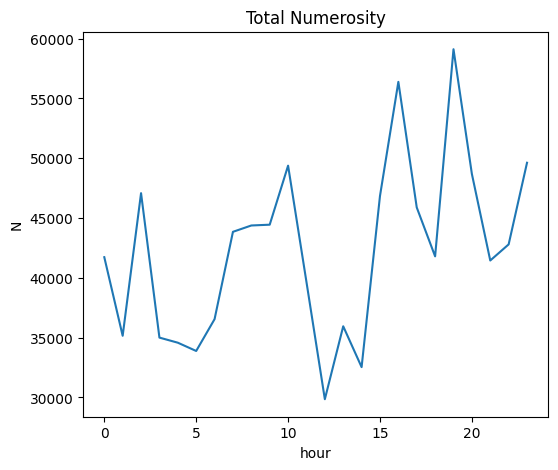

In [234]:
e.variability_per_time('hour')
print()
e.insight('hour', True)

**Day plot** (failed job section) <br/>
Nel class proportion plot per day, possiamo riscontrare un'andamento poco stabile...ora è necessario capire se alcuni giorni presentano questa distribuzione perche dietro vi è un pattern (giorno manutenzione per esempio, o giorno relativo ad aggiornamenti) o a causa di alcuni outliers. Quindi guardiamo variabilità:

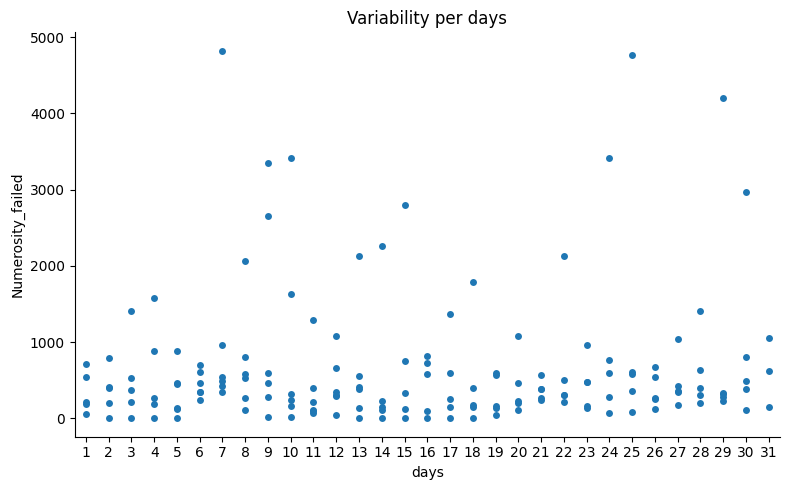

In [235]:
e.variability_per_time('day')

I picchi negativi presenti nel giorno 25 e 29, sono dovuti alla presenza di due outliers... Inoltre può essere utile specificare la presenza di una forte locality con gli user: ovvero lo stesso giorno, lo stesso user sottomette piu failed jobs.

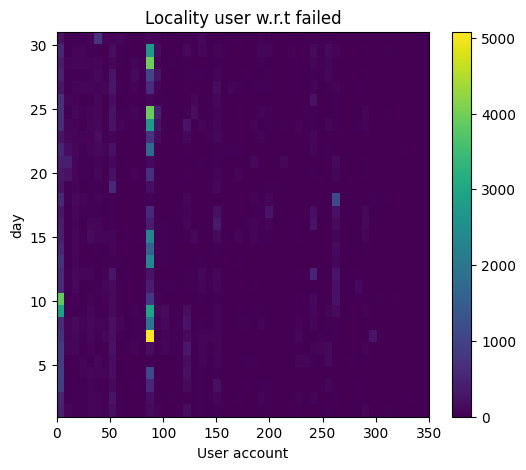

In [236]:
e.insight('day')

 The presence of big variability w.r.t time is present also in timeout and out of memory jobs

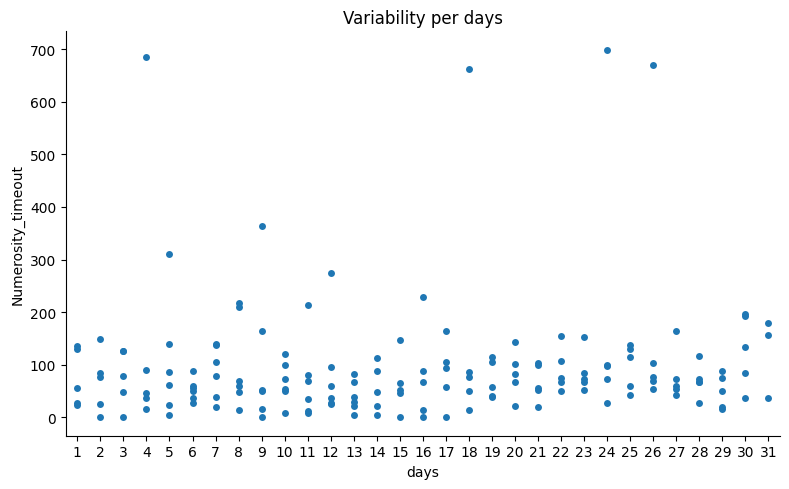

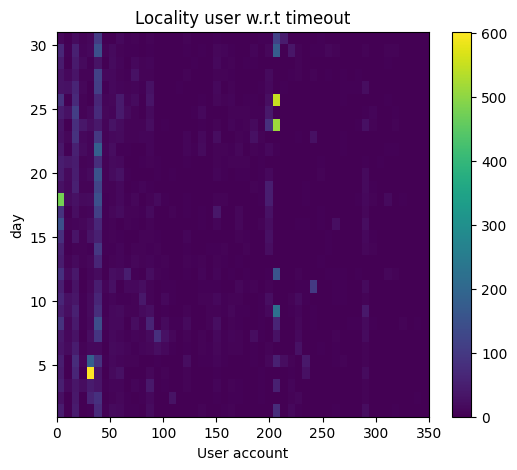

In [237]:
e.variability_per_time('day', type_job='TIMEOUT')
print()
e.insight('day', type_job='TIMEOUT')

In day 4, 24 and 26...we have high number of occurences of timeout jobs submitted by a user account

Ovviamente non si tratta di un **bad user**, perchè la distribuzione degli user non è uniforme... abbiamo necessità di esplorare di piu i dati, quindi plotto the rate of the top ten failed job submitters (also timeout and out_of_memory jobs)

In [238]:
print('Clearly not uniform \n')
print(dataframe_tmp_1['account'].value_counts())

Clearly not uniform 

iscrb_deftune       274194
hpce3_tosco         181606
iscrc_mdpapt_0      174899
iscrb_inwards_0      84957
cin_staff            69594
                     ...  
pra21_5415               1
fusio_ru4ipplm_0         1
iscrc_phenohd_0          1
iscrc_k-ado_0            1
ppp4x_5489               1
Name: account, Length: 351, dtype: int64


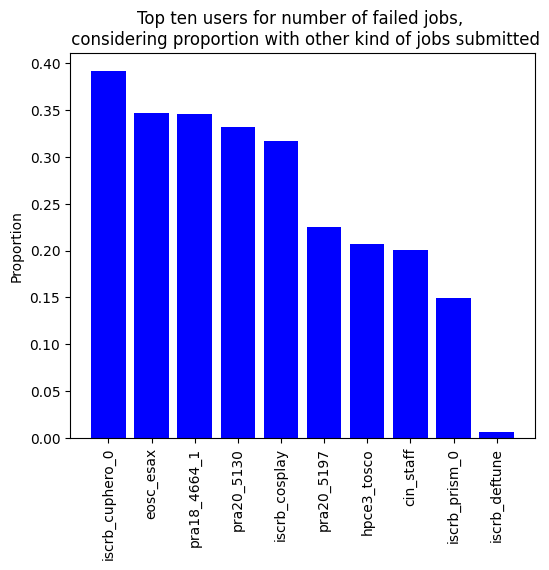

In [239]:
# top 10 failed job submitters
def submitters(job_state, data=dataframe_tmp_1):
  column = dataframe_tmp_1['job_state']
  mask = column == job_state
  a=dataframe_tmp_1['account'].loc[mask].value_counts()[:10] #first ten
  b=dataframe_tmp_1['account'].loc[dataframe_tmp_1['account'].isin(a.index.to_list())].value_counts() # total job submitted by that account
  return a/b #proportion

submitters_failed = submitters('FAILED').sort_values(ascending=False)
plt.bar(submitters_failed.index, submitters_failed.values, color='blue')
plt.xticks(submitters_failed.index, rotation=90)
plt.ylabel('Proportion')
plt.title('Top ten users for number of failed jobs, \n considering proportion with other kind of jobs submitted')
plt.show()

We do not have bad users --> proportions do not exceed 50%.

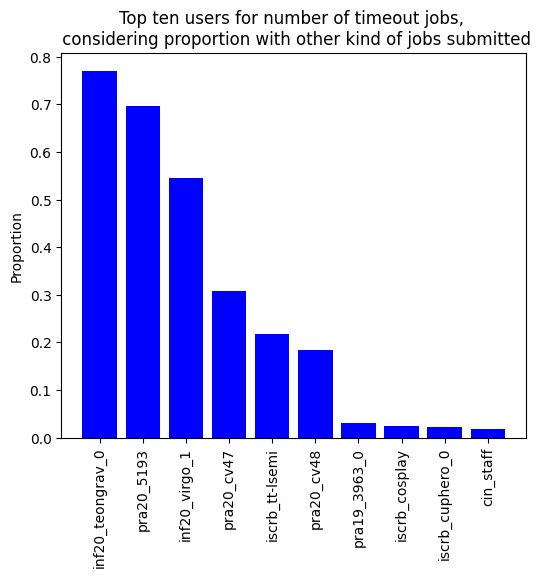

In [240]:
# timeout jobs
submitters_timeout = submitters('TIMEOUT').sort_values(ascending=False)
plt.bar(submitters_timeout.index, submitters_timeout.values, color='blue')
plt.xticks(submitters_timeout.index, rotation=90)
plt.ylabel('Proportion')
plt.title('Top ten users for number of timeout jobs, \n considering proportion with other kind of jobs submitted')
plt.show()

In [241]:
def hist(*x):
  lenn = len(x) // 2
  plt.figure(figsize=(13,5))
  for i,j in enumerate(x):
    plt.subplot(lenn,2,i+1)
    plt.hist2d(dataframe_tmp_1['time_limit'].loc[dataframe_tmp_1['account']==j].astype('int'), dataframe_tmp_1['num_mem_req'].loc[dataframe_tmp_1['account']==j])
    plt.xlabel('time limit in minutes')
    plt.ylabel('memory required')
    plt.title(f'account considered: {j}')
    plt.subplots_adjust(hspace=0.3, wspace = 0.4)
  plt.show()

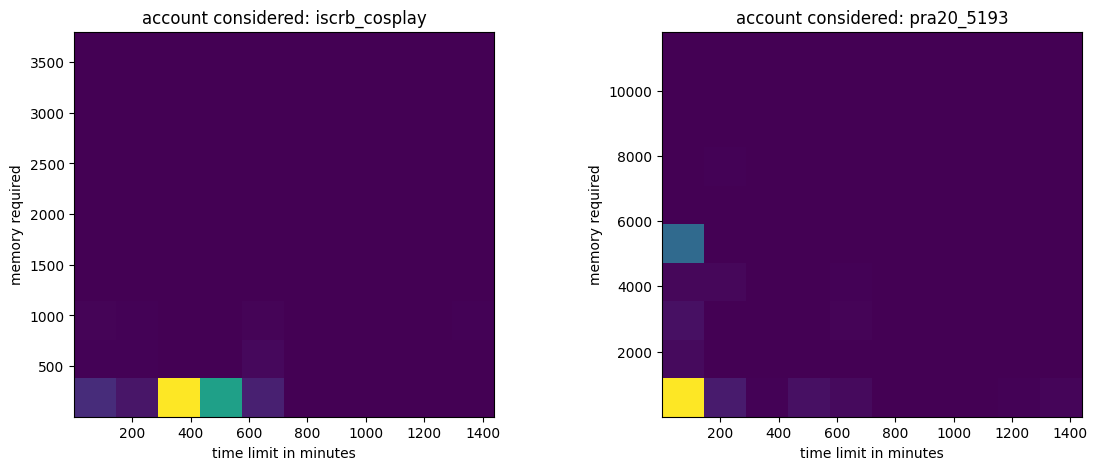

In [242]:
hist(submitters_timeout.index[7], submitters_timeout.index[1])

As we can see 'pra20_5193' assigns lower time_limit, so that's can be a cause for which it has many timeout submitted jobs

See other relations: out of memory jobs in general have a lower num memory allocation

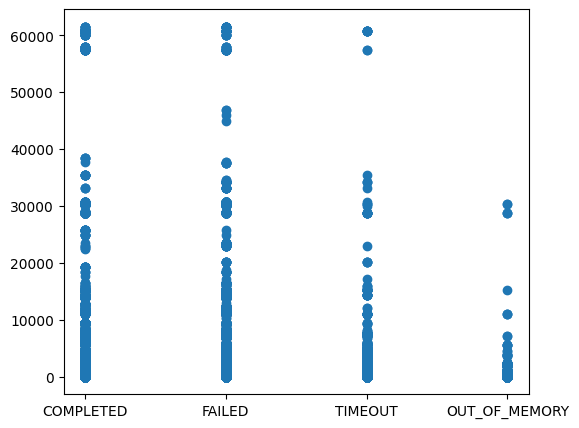

In [243]:
plt.scatter(dataframe_tmp_1['job_state'].values, dataframe_tmp_1['num_mem_alloc'].values)
plt.show()

Let's check other possible peculiarities for others variable

Now i wanna check the cumulative distribution of the difference between **submit_time** and **start_time** for the completed jobs and for the failed jobs, if there is any difference

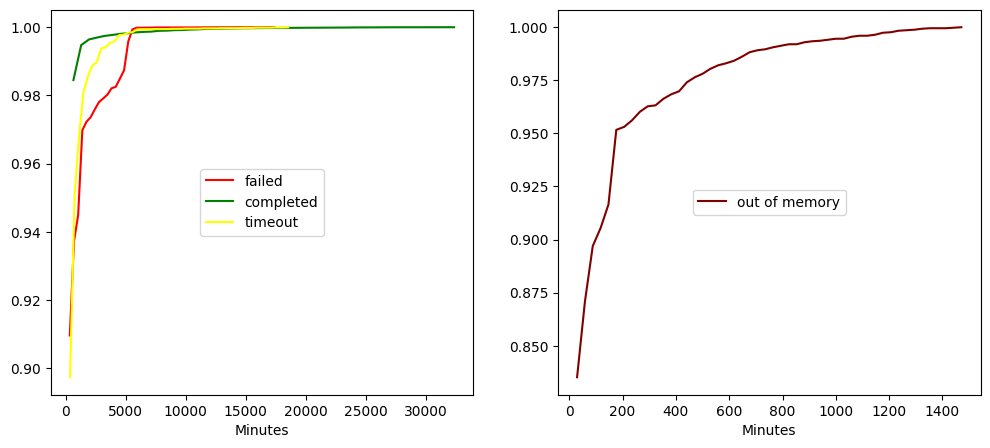

In [244]:
def cumulative(jobs='FAILED', data=dataframe_tmp_1, percentile=None):
  Delta = (dataframe_tmp_1['start_time'].loc[dataframe_tmp_1['job_state']==jobs] - dataframe_tmp_1['submit_time'].loc[dataframe_tmp_1['job_state']==jobs])
  Delta = Delta.dt.total_seconds() // 60 # in minutes
  if percentile:
    lenn=int(len(Delta)*(percentile/100))
    delta=Delta.sort_values().iloc[:lenn]
    nper_bin, bin_range = np.histogram(delta, bins=50)
    pdf = nper_bin / sum(nper_bin)
    return np.cumsum(pdf), bin_range, nper_bin
  else:
    nper_bin, bin_range = np.histogram(Delta, bins=50)
    pdf = nper_bin / sum(nper_bin)
    return np.cumsum(pdf), bin_range, nper_bin

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot((c:=cumulative('FAILED'))[1][1::], c[0], color='red', label='failed')
plt.plot((c:=cumulative('COMPLETED'))[1][1::], c[0], color='green', label='completed')
plt.plot((c:=cumulative('TIMEOUT'))[1][1::], c[0], color='yellow', label='timeout')
plt.xlabel('Minutes')
plt.legend(loc='center')
plt.subplot(1,2,2)
plt.plot((c:=cumulative('OUT_OF_MEMORY'))[1][1::], c[0], color='maroon', label='out of memory')
plt.legend(loc='center')
plt.xlabel('Minutes')
plt.show()

These distributions are too characterized by anomalies, try to consider until the 90th percentile (excluding in that way 'unsafe' values)

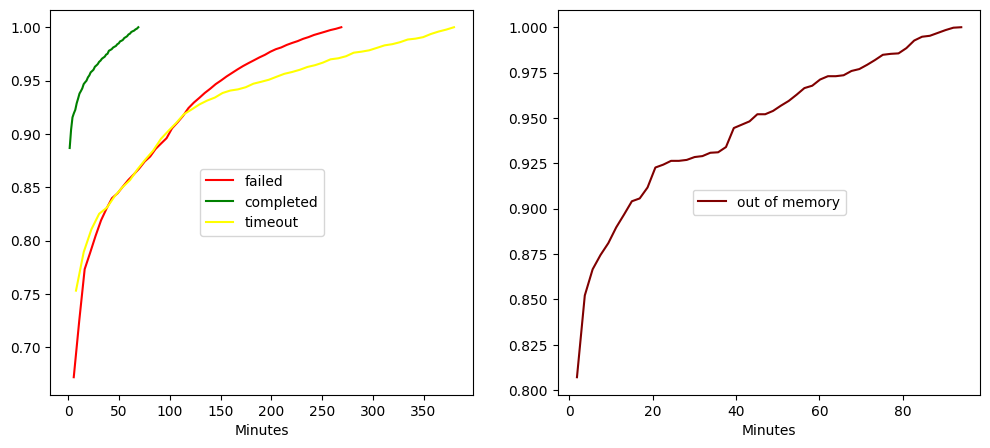

In [245]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot((c:=cumulative('FAILED', percentile=90))[1][1::], c[0], color='red', label='failed')
plt.plot((c:=cumulative('COMPLETED', percentile=90))[1][1::], c[0], color='green', label='completed')
plt.plot((c:=cumulative('TIMEOUT', percentile=90))[1][1::], c[0], color='yellow', label='timeout')
plt.xlabel('Minutes')
plt.legend(loc='center')
plt.subplot(1,2,2)
plt.plot((c:=cumulative('OUT_OF_MEMORY', percentile=90))[1][1::], c[0], color='maroon', label='out of memory')
plt.legend(loc='center')
plt.xlabel('Minutes')
plt.show()

We can say that all distributions, except for Completed jobs, show tails... Moreover we can say that the Delta values for completed jobs is in a more tight range.

#### Survival Analysis
Now to get more insights (to figure out some patterns, some submission job' behaviour).. I wanna compute the hazard rate --> the purpose is to catch peculiarities regarding failed jobs' submission inter-arrival time  (for simplicity and established that not completed jobs have similar features in a certain sense, i consider timeout, out of memory and failed jobs all under the failed label). I wanna know something more about frequency and timing.

Formula used to compute hazard rate --> **h(t) = f(t) / S(t)**. Where t is the inter arrival time, S is survival function, f is the probability density function. <br/>
As Survival function estimator, we will use Keplen Meier, a non parametric estimator

In [ ]:
class Hazard_rate:

  day_in_seconds = 24*60*60

  def __init__(self, data=dataframe_tmp_1):
    self.data = data[['submit_time', 'job_state']].copy()
    _ = self.processing()
    self.space = [Integer(2,15, name='layers'), Categorical([32,64], name='units'), Real(10**-6, 10**-4, 'log-uniform', name='L2'),
                  Real(10**-4, 10**-2, 'log-uniform', name='learning_rate')] #default is 0.001

  def processing(self):
    self.failed_data = self.data['submit_time'].loc[self.data['job_state']!='COMPLETED']
    self.failed_data = self.failed_data.sort_values().round('10S')
    self.delta = ((self.failed_data.iloc[1:].values - self.failed_data.iloc[:-1].values).astype('float64') / 10**9).astype('int') #in seconds

  def survival_function(self):
    # first compute probability density function for each inter-arrival time (rounded to multiple of 10seconds)
    unique, counts = np.unique(self.delta, return_counts=True)
    self.pdf = pd.Series(index=unique, data=counts/sum(counts))
    #we consider the inter-arrival as a sort of duration
    duration = self.delta
    #we don't have censored samples
    #I define the object
    kmf = KaplanMeierFitter()
    kmf.fit(duration)
    self.survival_function = kmf.survival_function_.values.flatten()
    kmf.plot()
    plt.xscale('log')
    plt.yscale('log')
    plt.yticks([10**x for x in range(-6,1)[::-1]])
    plt.ylabel('Proportion surviving')
    plt.xlabel('Inter-arrival time (s)')
    plt.title('Survival function')

  def hazard_rate(self):
    self.hazard_function = self.pdf[:-4] / self.survival_function[:-4] # i exclude some outliers (big interarrival time) likely due to the fact the data are uneven sampled
    plt.scatter(self.pdf.index[:-4], self.hazard_function)
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Hazard  function')
    plt.xlabel('Inter-arrival time (s)')
    plt.xticks([10**x for x in range(6)])
    plt.yticks([10**x for x in range(-4,1)[::-1]])
    plt.ylabel('Hazard rates')

  def __str__(self):
    return 'Number of inter-arrival samples with value greater than one day: {}'.format(len(self.delta[self.delta>self.day_in_seconds]))

In [ ]:
H = Hazard_rate()

Ovviamente avendo un dataset non uniformemente campionato da un punto di vista temporale, potremmo inserire un po di noise nella computazione della survival function, esempio '4 giorni di differenza tra due non completed jobs'...Ma verifichiamo subito che solo in due casi abbiamo l'interarrival superiore al 'giorno'. Quindi tutto ok

In [ ]:
print(H)

Number of inter-arrival samples with value greater than one day: 2


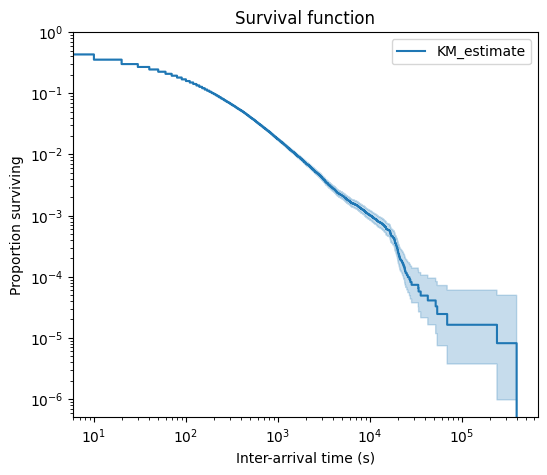

In [ ]:
H.survival_function()

Survival question --> **Which is the probability that after 100 seconds from the last failed jobs, a new failed jobs is not occurred?** <br/>
We can view ~ 25%. <br/>
We'll have great chances to obtain consecutive failed jobs (in a very short range of seconds). <br/>

High confidence interval towards the end of my function, probably because there we have few samples or due to the uneven distribution of time... we do not investigate too much since the proportions are very low <br/>

An additional insight can be provided by the hazard function...is not monotonically decreasing as survival function, so we can catch new aspects --> the point is: **Which is the probability of obtaining a failed jobs in an interval of time, given that is not occured before this interval**

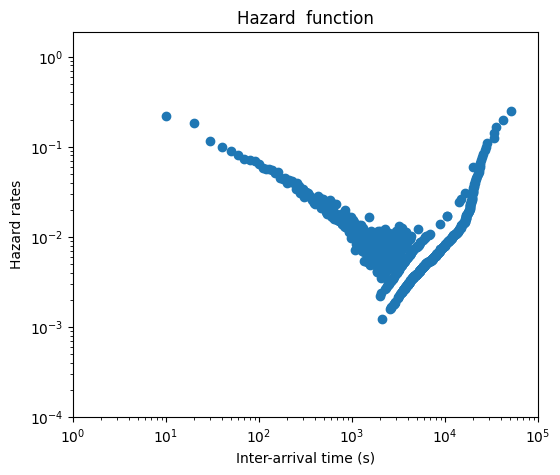

In [ ]:
H.hazard_rate()

We can view: Hazard rate of failed jobs' submission inter arrival time has a **V shape**: that means the probability of submitting a failed job, after the last failed job, decreases with the passing seconds until approximately 1000 seconds and then increase consinstently along with the time passing...thus failed jobs are either submitted continuously within short range of seconds or they are dispersi.
We know that having a not uniform temporal distribution of jobs, we need to be cautious to state 'judgements', but we can say one thing: **the vast majority of non completed jobs are submitted in a very short range of seconds by the same user** (we have seen that previously)... This happens because HPC users often submit jobs in batches.

---

We need to encode the non-numerical variables. As regards the 4 time variables, i encode (for the moment) submit time with hours...start time as minutes/hours difference with submit time...eligible time as minutes difference with submit time and...last sched eval as minutes difference with start time. <br/>
For which regard also time considered as info to add to my dataframe, we add columns indicating the month and the day the job was submitted.

In [246]:
class Encoding_2:

  def __init__(self, data=dataframe_tmp_1):
    self.data = data.copy()
    self.first_list = ['account', 'partition', 'qos', 'job_state', 'billable_tres', 'num_tasks'] #c,f,t,o
    self.pattern = re.compile('[A-Z]')
    self.pattern_2 = re.compile('\..+')

  def processing(self):
    if not isinstance(self.data['account'][0],str):
      return self.data
    else:
      self.data = self.encoding()
      self.data['day'], self.data['month'] = self.data['submit_time'].dt.day, self.data['submit_time'].dt.month
      self.data['last_sched_eval'] = self.data['last_sched_eval'].map(lambda x: re.sub(self.pattern_2, '+00:00',re.sub(self.pattern, ' ', x)))
      to_datetime = lambda x: pd.to_datetime(self.data[x], format='%Y.%m.%d %H:%M:%S')
      self.data['last_sched_eval'] = (self.data['start_time']-to_datetime('last_sched_eval')).dt.total_seconds()
      self.data['eligible_time'] = (to_datetime('eligible_time') - self.data['submit_time']).dt.total_seconds()
      self.data['start_time'] = (self.data['start_time'] - self.data['submit_time']).dt.total_seconds() // 60
      self.data['submit_time'] = self.data['submit_time'].dt.hour
      return self.data.drop(columns=['year_month']).astype('float')

  def encoding(self):
    for x in self.first_list:
      unique = list(pd.unique(self.data[x]))
      if '' in unique: self.data.loc[self.data[x]=='', x]=None # map '' in None
      else:
        d = dict(map(lambda x: (unique[x],x) , range(len(unique)))) # map in numeric domain categorical variable
        self.data[x] = self.data[x].map(d)
    return self.data

In [247]:
dataframe_tmp_2 = Encoding_2().processing()

### Imputing missing values

In [248]:
print((d:=dataframe_tmp_2.isnull().any())[d==True])
missing_variables = list(d[d==True].index)

num_tasks        True
billable_tres    True
num_mem_alloc    True
gpu_alloc        True
dtype: bool


We have missing values in four variables. Now we need to define the imputing methods and test them for which regard the performance.<br/>
The methods will be:
- median or mean value
- neural regression model<br/>

This two methods will be applied for each of the 4 variables.


Obviously we will test our techinques in a masked set (we know the values, but we substitute them with None purposely).

In [249]:
class CustomCallback(keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs=None):
    if epoch % 20 == 0: print('')
    print('..', end='')

In [250]:
from sklearn.model_selection import train_test_split

class Fill_none:

  def __init__(self, target_variable, other_miss_variables=missing_variables, data=dataframe_tmp_2, size_valset=0.1):
    self.dataframe = pd.DataFrame(columns=['median', 'neural regression', 'gaussian_processes'])
    self.data = data.copy()
    self.target_variable = self.data[target_variable].copy()
    self.data.drop(columns=missing_variables, inplace=True)
    #real set with missing values
    self.real_set, self.real_target = self.data.loc[(m:=self.target_variable.isnull())], self.target_variable[m]
    self.data, self.target_variable = self.data[~m], self.target_variable[~m]
    self.train_set, self.test_set, self.train_target, self.test_target = train_test_split(self.data, self.target_variable, random_state=41, test_size=size_valset)

  def median_(self):
    check = lambda x,y: x if not self.stand_target else x*y
    self.median = self.train_target.sort_values().iloc[math.ceil(len(self.data)/2)]
    self.mae = tf.keras.losses.MeanAbsoluteError()(self.test_target.values, np.array([self.median]*len(self.test_target.values)))
    self.mae = check(self.mae, self.std_target)
    self.dataframe.loc[self.target_variable.name, 'median'] = self.mae.numpy()
    return self.mae

  def standardize(self, stand_target=False):
    self.stand_target = stand_target
    check = lambda x,y,z: x.astype('float64') if not self.stand_target else ((x-y)/z).astype('float32')
    #we dont wanna standardize cat variables
    self.to_standardize = [x for x in self.data.columns if x not in ['ntasks_per_socket_str', 'contiguous', 'shared']]
    self.mean = self.train_set[self.to_standardize].mean(axis=0)
    self.std = self.train_set[self.to_standardize].std(axis=0).replace(to_replace=0, value=1)
    self.train_set[self.to_standardize] = ((self.train_set[self.to_standardize] - self.mean) / self.std).astype('float32')
    self.test_set[self.to_standardize] = ((self.test_set[self.to_standardize] - self.mean) / self.std).astype('float32')
    self.real_set[self.to_standardize] = ((self.real_set[self.to_standardize] - self.mean) / self.std).astype('float32')
    self.mean_target, self.std_target = self.train_target.mean(), self.train_target.std()
    self.train_target, self.test_target = check(self.train_target, self.mean_target, self.std_target), check(self.test_target, self.mean_target, self.std_target)
    return 'Ok'

  def regression_model(self, output_shape, hidden, **other_params):
    self.early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    model_in = keras.Input(shape=len(self.train_set.columns), dtype='float32')
    x = model_in
    for h in hidden:
      x = layers.Dense(h, activation='relu', **other_params)(x)
    model_out = layers.Dense(output_shape, activation='linear')(x)
    self.model = keras.Model(model_in, model_out)
    return self.model

  def modified_mae_loss(self,true, predictions): # I don t wanna values lower than 0
    self.error = tf.abs(true-predictions)
    self.negative_penalty = tf.square(tf.maximum(-predictions,0))
    self.loss = tf.reduce_mean(self.error+self.negative_penalty)
    return self.loss

  def train_nn_model(self, optimizer='rmsprop', metric=None, loss=None, **fit_params):
    self.model.compile(optimizer=optimizer,loss=(loss if loss else self.modified_mae_loss), metrics=metric)
    self.history = self.model.fit(self.train_set, self.train_target, callbacks=[self.early_stopping, CustomCallback()], **fit_params)
    return self.history

  def plot_history(self):
    self.epochs = len(self.history.history['loss'])
    plt.plot(np.arange(self.epochs), self.history.history['val_loss'], 'bo', label='Validation loss')
    plt.plot(np.arange(self.epochs), self.history.history['loss'], 'b', label='Training loss')
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    return f"best val_loss: {self.history.history['val_loss'][-16]}"

  def predict(self, method:str, decimal=0):
    self.decimal = decimal
    check = lambda x,y: x if not self.stand_target else x*y
    self.max, self.min = self.test_target.max(), self.test_target.min()
    self.predictions = self.model.predict(self.test_set)
    self.predictions, self.target = self.predictions.reshape(-1).round(self.decimal), np.asarray(self.test_target.values)
    self.mae = check(tf.keras.losses.MeanAbsoluteError()(self.predictions, self.target), self.std_target)
    plt.scatter(self.predictions, self.test_target)
    plt.title('Predictions vs Real values')
    plt.xlabel('Predictions')
    plt.ylabel('Real values')
    self.lims = [self.min,self.max]
    plt.xlim(self.lims)
    plt.ylim(self.lims)
    plt.plot(self.lims, self.lims)
    plt.show()
    self.dataframe.loc[self.target_variable.name, method] = self.mae.numpy()
    return f"That's the mae for the {method} approach: {self.mae} " + ('' if not self.stand_target else "(It's already mult with std)")

  def plot_residuals(self):
    self.errors = self.predictions - self.target
    plt.scatter(self.errors, self.target)
    plt.xlabel('Residual errors')
    plt.ylabel('Target values')
    plt.title('Residual Inspection')

  def real_predictions(self):
    return self.model.predict(self.real_set).reshape(-1).round(self.decimal)



**The peaks or fluctuations on validation loss are due to the penalty that I added to MAE if the predicted value is negative**

In [251]:
#range of num_mem_alloc values is large, but the final results are pretty the same, so no standardization of target variable
print(f"Large range -> {(dataframe_tmp_2['num_mem_alloc'].min(), dataframe_tmp_2['num_mem_alloc'].max())}")
num_mem_alloc_instance = Fill_none('num_mem_alloc')
_ = num_mem_alloc_instance.standardize(stand_target=False)

Large range -> (0.002, 61500.0)


In [252]:
_ = num_mem_alloc_instance.regression_model(output_shape=1, hidden=[32,32], kernel_regularizer=keras.regularizers.L1(0.00001))

history = num_mem_alloc_instance.train_nn_model(validation_split=0.1,verbose=0, epochs=500, batch_size=512)


........................................
........................................
........................................
........................................
........................................
............

In [253]:
num_mem_alloc_instance.model.save(os.path.join(save_directory, 'num_mem_alloc_instance.h5')) # we save the model

'best val_loss: 2.062312364578247'

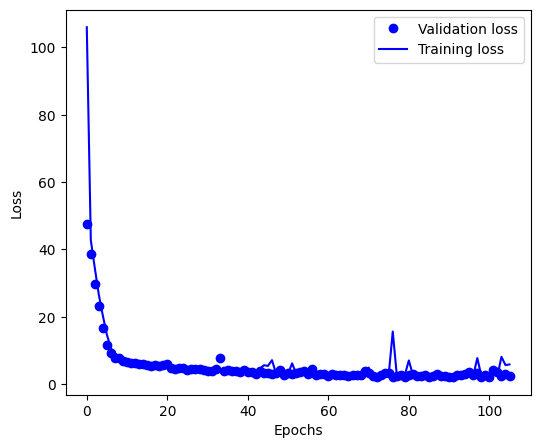

In [254]:
num_mem_alloc_instance.plot_history()

3174/3174 [==============================] - 4s 1ms/step


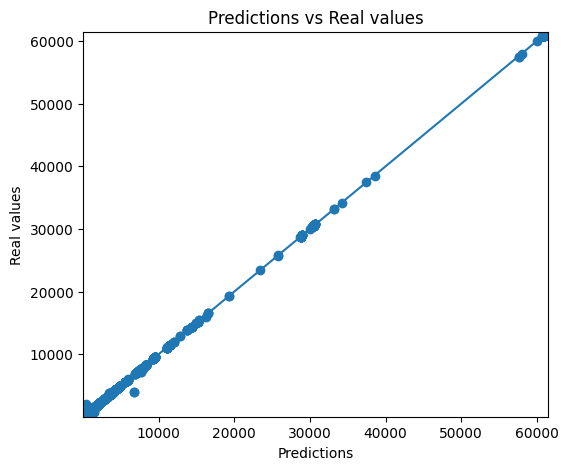

"That's the mae for the neural regression approach: 4.478490845231028 "

In [255]:
num_mem_alloc_instance.predict('neural regression', decimal=1)

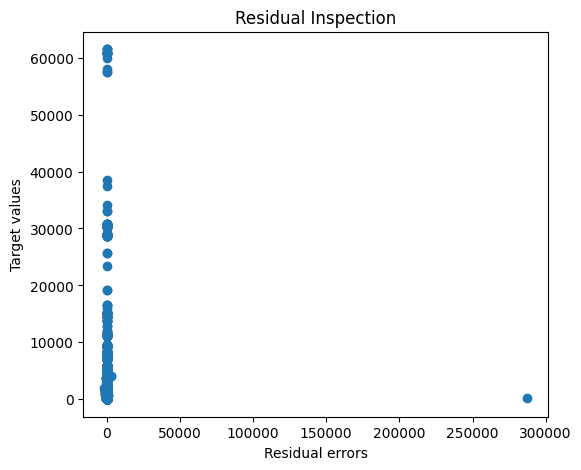

In [256]:
# I wanna get some infos from residuals
num_mem_alloc_instance.plot_residuals()

I figure out one important thing: there is an outlier error, i need to inspect it...Why? It's a bit unusual, I need to check that row in the real dataframe --> noisy data can have negative effect on my model, this is an example

In [257]:
index_noisy = np.argmax(num_mem_alloc_instance.errors)
label_index = num_mem_alloc_instance.test_set.iloc[index_noisy].name
print(dataframe_tmp_1.loc[label_index])

pn_min_cpus                                    128
ntasks_per_socket_str                          0.0
contiguous                                     0.0
priority                                    149034
num_nodes                                        1
year_month                                   20-10
pn_min_memory                                 1900
nice                                             0
ntasks_per_node                                  1
ntasks_per_core_str                            0.0
account                               phd_aimageth
start_time               2020-10-09 15:57:05+00:00
partition                            m100_usr_prod
num_tasks                                        1
qos                                         normal
num_cpus                                       128
time_limit                                    1440
job_state                                  TIMEOUT
submit_time              2020-10-09 11:59:33+00:00
billable_tres                  

In eligible time feature we have an erroneous data, so we drop that row from my dataframe (I showed dataframe_tmp_1 over 2 because in the first one it's not encoded, so likely more understandable)

In [258]:
try_this(lambda: dataframe_tmp_2.drop(label_index, inplace=True), 'Row already dropped')

In [259]:
#we define a new instance, we load old model (in this way test_set is updated)
num_mem_alloc_instance_2 = Fill_none('num_mem_alloc', data=dataframe_tmp_2) # in this way we get an updated test_set
_ = num_mem_alloc_instance_2.standardize()

In [260]:
_ = num_mem_alloc_instance_2.regression_model(output_shape=1, hidden=[32,32], kernel_regularizer=keras.regularizers.L1(0.00001))

history = num_mem_alloc_instance_2.train_nn_model(validation_split=0.1,verbose=0, epochs=500, batch_size=512)


........................................
........................................
........................................
........................................
....................

In [261]:
num_mem_alloc_instance_2.model.save(os.path.join(save_directory, 'num_mem_alloc_instance_2.h5'))

'best val_loss: 2.4635045528411865'

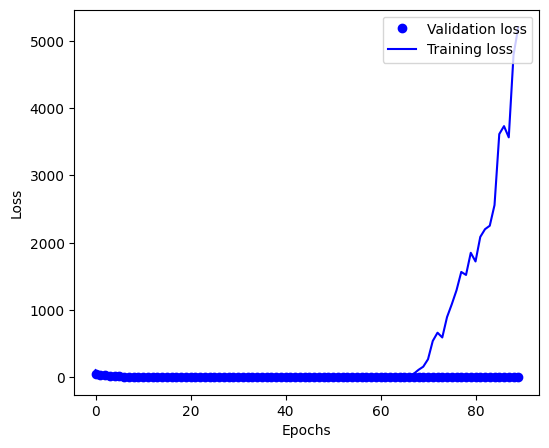

In [262]:
num_mem_alloc_instance_2.plot_history()

3174/3174 [==============================] - 4s 1ms/step


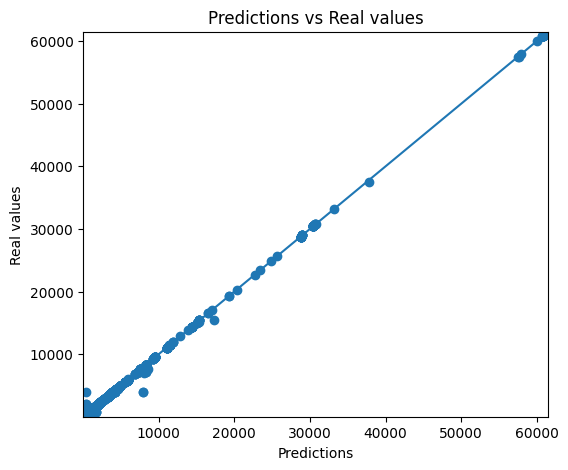

"That's the mae for the neural regression approach: 2.0140965654937717 "

In [263]:
num_mem_alloc_instance_2.predict('neural regression', decimal=1)

In [264]:
num_mem_alloc_instance_2.median_()

<tf.Tensor: shape=(), dtype=float64, numpy=224.88685686430915>

My MeanAbsoluteError it's obviously better... we continue with other variables

In [265]:
gpu_instance = Fill_none('gpu_alloc', data=dataframe_tmp_2)
_ = gpu_instance.standardize() # no standardization of target variable

In [266]:
_ = gpu_instance.regression_model(output_shape=1, hidden=[32,32], kernel_regularizer=keras.regularizers.L1(0.000025))

history = gpu_instance.train_nn_model(validation_split=0.1,verbose=0, epochs=500, batch_size=512)


........................................
........................................
........................................
........................................
................

In [267]:
gpu_instance.model.save(os.path.join(save_directory, 'gpu_alloc.h5'))

I wanna a more stable validation loss signal, too fluctuation...So i've inserted another 'regularization term': L1

'best val_loss: 0.05823877826333046'

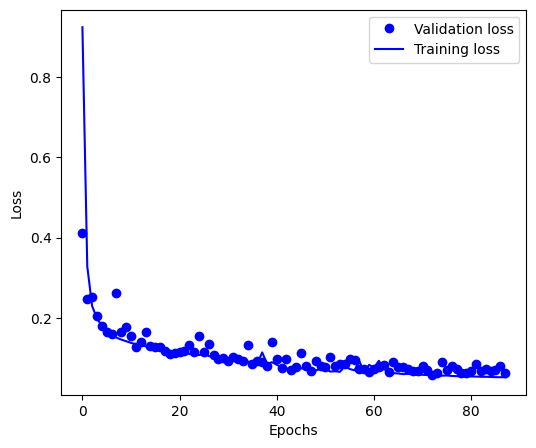

In [268]:
gpu_instance.plot_history()

3174/3174 [==============================] - 4s 1ms/step


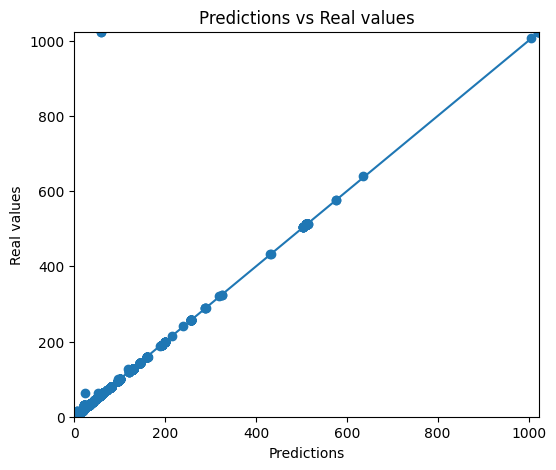

"That's the mae for the neural regression approach: 0.02496380986144347 "

In [269]:
gpu_instance.predict('neural regression')

We don t need to check the distributions of residuals--> the predictions are very good <br/>

In [270]:
gpu_instance.median_()

<tf.Tensor: shape=(), dtype=float64, numpy=4.629344047583878>

Now we proceed with the other variables that have missing values




In [271]:
#range of billable_tres values is quite large however I didn’t notice an improvement in performance, on the contrary...so no standardization
print(f"Quite large range -> {(dataframe_tmp_2['billable_tres'].min(), dataframe_tmp_2['billable_tres'].max())}")
billable_tres_instance = Fill_none('billable_tres', data=dataframe_tmp_2)
_ = billable_tres_instance.standardize()

Quite large range -> (4.0, 32768.0)


In [272]:
_ = billable_tres_instance.regression_model(output_shape=1, hidden=[32,32], kernel_regularizer=keras.regularizers.L1(0.000025))

history = billable_tres_instance.train_nn_model(validation_split=0.1,verbose=0, epochs=500, batch_size=512)


........................................
........................................
........................................
........................................
........................................
..

In [273]:
billable_tres_instance.model.save(os.path.join(save_directory, 'billable_tres.h5'))

'best val_loss: 0.20852287113666534'

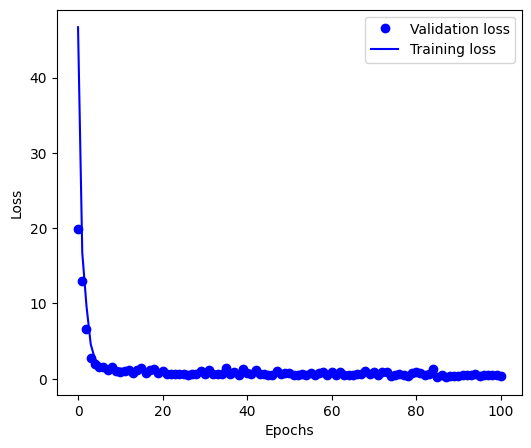

In [274]:
billable_tres_instance.plot_history()

3174/3174 [==============================] - 4s 1ms/step


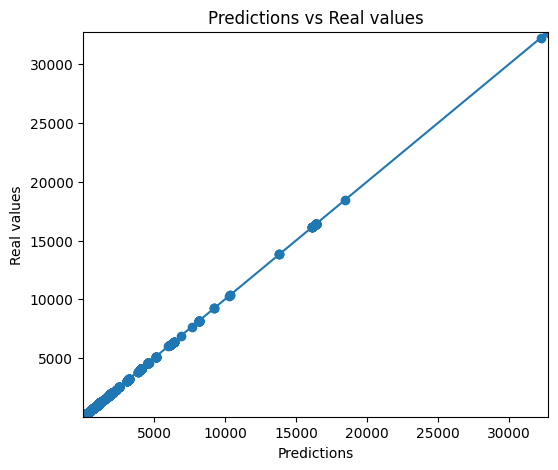

"That's the mae for the neural regression approach: 0.11869380680866988 "

In [275]:
billable_tres_instance.predict('neural regression')

In [276]:
billable_tres_instance.median_()

<tf.Tensor: shape=(), dtype=float64, numpy=120.73345347474569>

In [277]:
# last variable: num_tasks
p = pd.unique(dataframe_tmp_2['num_tasks'])
print(f'This is the range for num_tasks variable: {(min(p),max(p))}')#large range
num_tasks_instance = Fill_none('num_tasks', data=dataframe_tmp_2)
_ = num_tasks_instance.standardize()

This is the range for num_tasks variable: (0.0, 32768.0)


In [278]:
_ = num_tasks_instance.median_()
_ = num_tasks_instance.regression_model(output_shape=1, hidden=[32,32], kernel_regularizer = keras.regularizers.L1(0.000025))
history = num_tasks_instance.train_nn_model(validation_split=0.1, verbose=0, epochs=550, batch_size=512)


........................................
........................................
........................................
........................................
........................................
........................................
........................................
........................................
........................................
....................

In [279]:
num_tasks_instance.model.save(os.path.join(save_directory, 'num_tasks_instance_weights.h5'))

'best val_loss: 0.4977431297302246'

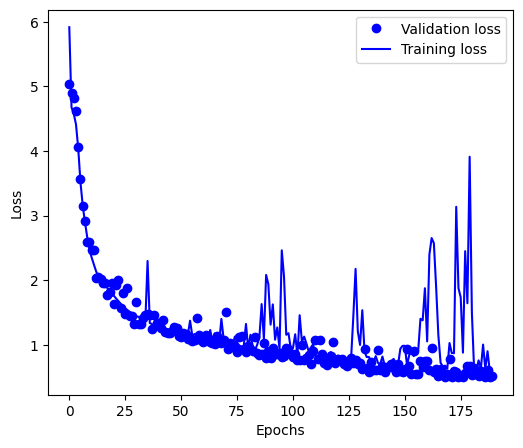

In [280]:
num_tasks_instance.plot_history()

3059/3059 [==============================] - 3s 1ms/step


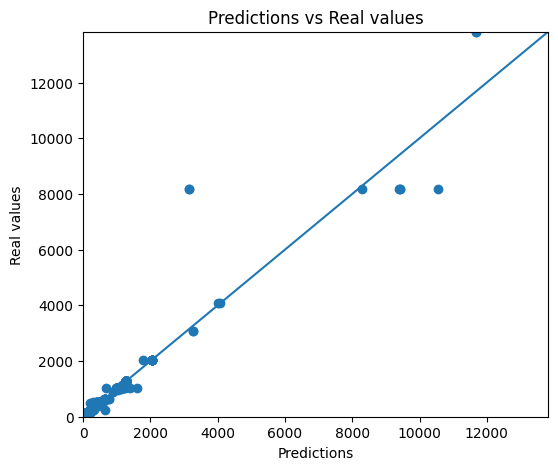

"That's the mae for the neural regression approach: 0.46404520790116394 "

In [281]:
num_tasks_instance.predict('neural regression')

In [282]:
pd.concat([num_tasks_instance.dataframe, gpu_instance.dataframe, num_mem_alloc_instance_2.dataframe, billable_tres_instance.dataframe], axis=0)

,median,neural regression,gaussian_processes
num_tasks,12.852175,0.464045,NaN
gpu_alloc,4.629344,0.024964,NaN
num_mem_alloc,224.886857,2.014097,NaN
billable_tres,120.733453,0.118694,NaN


For what concerns the Mean Absolute Error in neural regression model, all of these ones are excellent. So now we fill the missing values for each variable

In [283]:
my_instances = [num_tasks_instance, billable_tres_instance, num_mem_alloc_instance_2, gpu_instance]
for x,y in enumerate(my_instances):
  predictions = y.real_predictions()
  predictions[predictions<0] = 0 #if there exists
  dataframe_tmp_2.loc[y.real_set.index,missing_variables[x]] = predictions

34/34 [==============================] - 0s 1ms/step


In [284]:
dataframe_tmp_2.isnull().any().any()

False

Now I start my analysis on target variable: 'job_state'... Show a global picture of the domain values of this variable (before I standardize it)

In [285]:
target_variable = dataframe_tmp_2.pop('job_state')

In [286]:
from keras.utils import to_categorical
to_standardize = [x for x in dataframe_tmp_2.columns if x not in ['ntasks_per_socket_str', 'contiguous', 'shared']] #boolen variables
# I've used stratify in that way I avoid bad case --> test set only one kind of job, and I m loyal to the distribution
train_set, test_set, train_target, test_target = train_test_split(dataframe_tmp_2, target_variable, random_state=41, test_size=0.1, stratify=target_variable)
train_target_cat, test_target_cat = to_categorical(train_target.values), to_categorical(test_target.values)
mean, std = train_set[to_standardize].mean(axis=0), train_set[to_standardize].std(axis=0).replace(to_replace=0, value=1)
train_set[to_standardize]  = ((train_set[to_standardize] - mean) / std).astype('float32')
test_set[to_standardize] = ((test_set[to_standardize] - mean) / std).astype('float32')

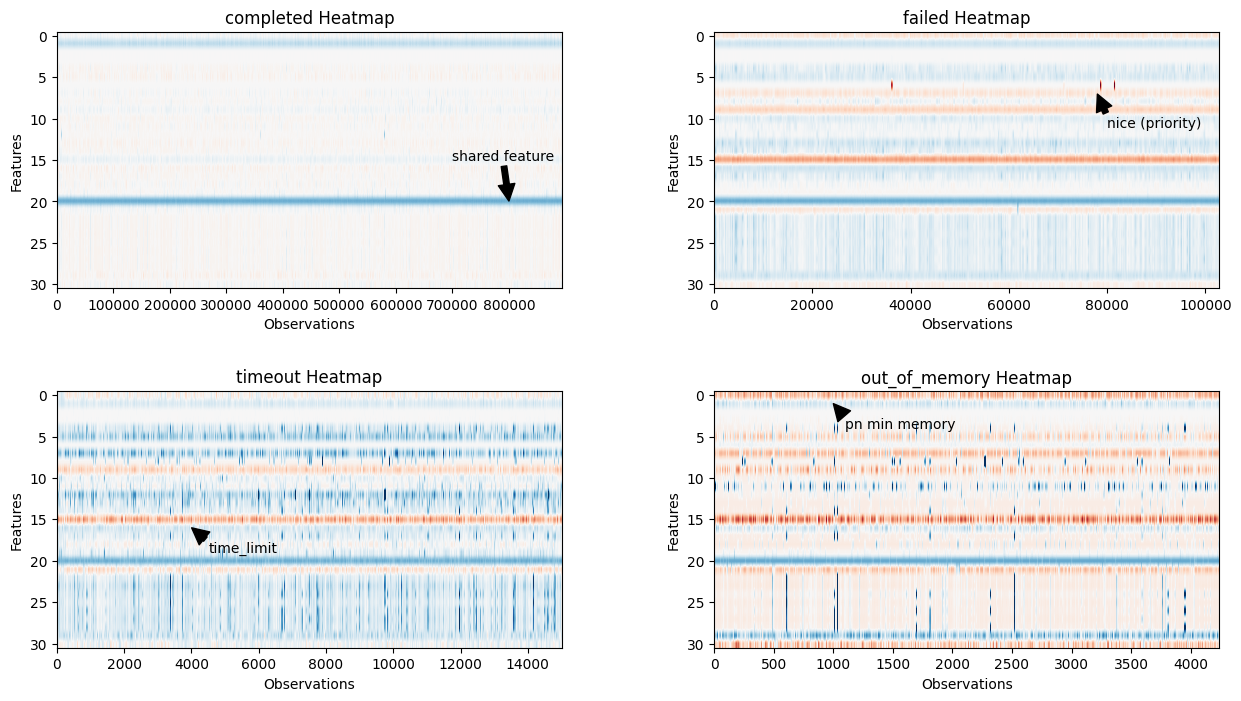

In [287]:
# now we redefine the entire dataset,to have a general view
plt.figure(figsize=(15,8))
def plot_dataframe(target_variable=target_variable, *sett):
  entire = pd.concat(sett, axis=0)
  dic = {'completed': ('shared feature', (800000, 20), (700000, 15)),
            'failed': ('nice (priority)', (78000, 7), (80000, 11)),
            'timeout': ('time_limit', (4000, 16), (4500, 19)),
            'out_of_memory': ('pn min memory', (1000, 1), (1100, 4))}
  for x,y in enumerate(['completed', 'failed', 'timeout', 'out_of_memory']):
    plt.subplot(2,2,x+1)
    plt.imshow(entire.loc[target_variable==x].T.iloc[:,:], vmin=-1.96, vmax=1.96, cmap='RdBu', aspect='auto')
    plt.xlabel('Observations')
    plt.ylabel('Features')
    plt.title(f'{y}' + ' Heatmap')
    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    text, xy, xy_text = dic[y]
    plt.annotate(text,xy=xy,xytext=xy_text,arrowprops=dict(facecolor='black', shrink=0.01))


plot_dataframe(target_variable, train_set, test_set)

How we can see here, in **completed plot** we have a homogeneous situation, many values are on the mean...In the **other plots** we have different situations, but no clear pattern

Now we can start our classification tasks, we define a 'big class' **Classification** where all the three method will be tested: <br/>
- SVM
- XGBoost
- Neural Classificaton Model <br/>

For the 'parameter optimization process' I will use Surrogate Bayesian Optimization process...with GP.








## Classification

### SVM
Sadly, applying SVM (with kernel trick) on a 1 mil dataset is quite 'heavy' (complexity ~ O(n<sup>3</sup>)). So we try this apprach:<br/>
- Downsampling

Obviously we lose infos and we can introduce some bias (if the right representiveness of classes is not maintained...). <br/>
I perform downsampling in that way: in my training set I will have a pretty balanced situation (so heavily downsampling the major class)... Instead I m going to have a validation set and a test set that maintain the original distribution of classes...otherwise the entire process is too biased. Balance consistency-complexity.<br/>

In [ ]:
class SVM:

  def __init__(self, data=dataframe_tmp_2, target=target_variable, to_standardize=to_standardize):
    self.data = data.copy()
    self.target = target.copy()
    self.to_standardize = to_standardize
    self.C = Real(0.001, 100)
    self.gamma = Real(0.01, 10)
    self.dataframe = pd.DataFrame(columns=['precision', 'recall', 'f1'])

  def standardize(self):
    stand = lambda x,mean,std: ((x-mean)/std).astype('float32')
    self.completed, self.failed, self.timeout, self.out_of_memory = list(map(lambda x: self.data.loc[self.target==x], sorted(pd.unique(self.target))))
    self.completed, self.failed = list(map(lambda x: resample(x[0], replace=False, random_state=41, n_samples=x[1]), [(self.completed, 4*10**4),(self.failed, 2*10**4)]))
    self.entire = pd.concat([self.completed, self.failed, self.timeout, self.out_of_memory])
    self.target = self.target.loc[self.entire.index]
    self.validation_set, self.validation_target = self.partition(0.3)
    self.test_set, self.test_target = self.partition(0.2)
    self.train_set, self.train_target = self.entire, self.target
    self.mean, self.std = self.train_set[self.to_standardize].mean(axis=0), self.train_set[self.to_standardize].std(axis=0).replace(to_replace=0, value=1)
    self.validation_set[self.to_standardize], self.test_set[self.to_standardize] = stand(self.validation_set[self.to_standardize], self.mean, self.std), stand(self.test_set[self.to_standardize], self.mean, self.std)
    self.train_set[self.to_standardize] = stand(self.train_set[self.to_standardize], self.mean, self.std)
    return 'Ok'

  def partition(self, percent_split, classes_proportions=[0.845, 0.10, 0.05, 0.005]):
    resampling = lambda x,y: resample(x, random_state=41, replace=False, n_samples=y)
    n_obs = int(len(self.entire)*percent_split)
    sett = pd.concat(list(map(lambda x: resampling(self.entire.loc[self.target==x[0]], int(n_obs*x[1])),
                                                     enumerate(classes_proportions))), axis=0)
    sett_target = self.target.loc[sett.index]
    self.entire.drop(sett.index, inplace=True)
    self.target.drop(sett.index, inplace=True)
    return sett, sett_target

  def __call__(self, *params):
    support_vector_machine = SVC(C=params[0][0], gamma=params[0][1], kernel='rbf', class_weight={0:1, 1:1, 2:1, 3:2}) #more weights on the last class otherwise its peculiarities are not catched
    support_vector_machine.fit(self.train_set, self.train_target.values)
    self.predictions = support_vector_machine.predict(self.validation_set)
    return self.metric()

  def metric(self):
    self.precision_arr = np.round(np.asarray(precision_score(self.validation_target, self.predictions, average=None)), 3)
    self.recall_arr = np.round(np.asarray(recall_score(self.validation_target, self.predictions, average=None)), 3)
    self.F1_arr = np.round(np.asarray(f1_score(self.validation_target, self.predictions, average=None)),3)
    self.F1_macro = np.round(np.sum(self.F1_arr) / len(self.F1_arr),3)
    #dataframe.loc[self.F1_macro] = [self.precision_arr, self.recall_arr, self.F1_arr]
    print(f'F1_macro: {self.F1_macro}, F1: {self.F1_arr}, Precision: {self.precision_arr}, Recall: {self.recall_arr}')
    return - self.F1_macro # the purpose is minimization


In [ ]:
s = SVM()
_ = s.standardize()

In [ ]:
%%time
res = gp_minimize(s, dimensions=[s.C,s.gamma], acq_func='LCB', n_calls=8, kappa = 1.96, # definition of Z in Lower confidence bound
                  x0=[[6,0.01],[1,1]], n_initial_points=3, noise=None, random_state=41, verbose=False) # two starting points defined
# I will have 2 execution of SVM with hyperparameters defined in x0, then 3 execution on random values, then exploration/exploitation

F1_macro: 0.458, F1: [0.782 0.37  0.523 0.156], Precision: [0.992 0.244 0.41  0.086], Recall: [0.645 0.765 0.721 0.847]
F1_macro: 0.613, F1: [0.887 0.539 0.673 0.353], Precision: [0.997 0.39  0.546 0.223], Recall: [0.8   0.869 0.878 0.847]
F1_macro: 0.648, F1: [0.91  0.612 0.605 0.464], Precision: [0.995 0.478 0.46  0.317], Recall: [0.839 0.851 0.881 0.864]
F1_macro: 0.638, F1: [0.907 0.622 0.547 0.474], Precision: [0.996 0.499 0.392 0.327], Recall: [0.833 0.824 0.903 0.864]
F1_macro: 0.639, F1: [0.908 0.63  0.527 0.49 ], Precision: [0.996 0.515 0.372 0.341], Recall: [0.834 0.812 0.907 0.873]
F1_macro: 0.649, F1: [0.911 0.611 0.61  0.463], Precision: [0.995 0.476 0.467 0.316], Recall: [0.84  0.852 0.878 0.864]
F1_macro: 0.652, F1: [0.907 0.578 0.694 0.427], Precision: [0.995 0.43  0.583 0.285], Recall: [0.832 0.881 0.857 0.856]
F1_macro: 0.631, F1: [0.903 0.623 0.51  0.488], Precision: [0.997 0.509 0.354 0.34 ], Recall: [0.826 0.803 0.914 0.864]
CPU times: user 43min 39s, sys: 687 ms, 

Best C:6.594 and best gamma:1.972


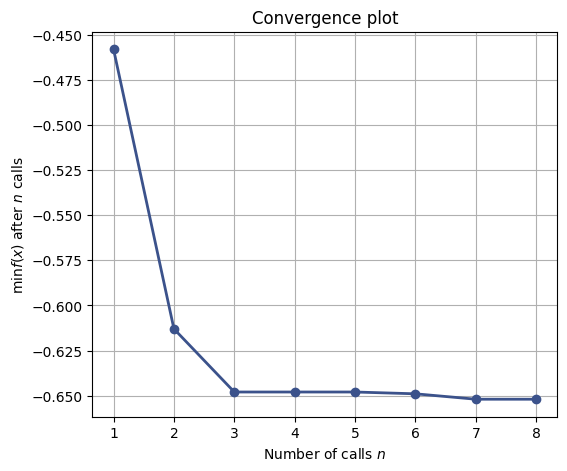

In [ ]:
C, gamma = np.round(res.x,3)
print(f'Best C:{C} and best gamma:{gamma}')
plot_convergence(res)
plt.show()

In [ ]:
my_model = SVC(kernel='rbf', C=C, gamma=gamma, class_weight={0:1, 1:1, 2:1, 3:2}) #new model trained with best hyperparamters
my_model.fit(s.train_set, s.train_target.values)
predictions = my_model.predict(s.test_set)
precision, recall, f1 = np.round(list(map(lambda x: x(s.test_target.values, predictions, average=None), [precision_score, recall_score, f1_score])),3)
f1_macro = np.round(sum(f1) / len(f1), 3)
print(f"That's the F1 macroaverage obtained on the test set: {f1_macro}") # --> it's so bad
print(f"Other metrics: Precision:{precision}, Recall:{recall}, F1:{f1}")

That's the F1 macroaverage obtained on the test set: 0.644
Other metrics: Precision:[0.995 0.421 0.562 0.288], Recall:[0.826 0.88  0.845 0.818], F1:[0.903 0.569 0.675 0.427]


In [294]:
# now we are going to inspect f1_macro, visualizing precision and recall
from sklearn.metrics import confusion_matrix as cf
def plot_rec_prec(target, predictions):
  plt.figure(figsize=(7,11))
  confusion_matrix = cf(target, predictions)
  recall_focus = confusion_matrix / confusion_matrix.sum(axis=1).reshape(-1,1)
  precision_focus = confusion_matrix / confusion_matrix.sum(axis=0)
  plt.subplot(2,1,1)
  plt.imshow(precision_focus, cmap='Blues', vmin=0.0, vmax=1.0)
  plt.title('Precision focus', pad=20)
  axis()
  plt.annotate(text='', xytext=(0.0,0.3), xy=(0.0,1.5), arrowprops=dict(facecolor='black', shrink=0.01))
  plt.subplots_adjust(hspace=0.4)
  plt.colorbar()
  plt.subplot(2,1,2)
  plt.imshow(recall_focus, cmap='Blues', vmin=0.0, vmax=1.0)
  plt.title('Recall focus', pad=20)
  axis()
  plt.annotate(text='', xytext=(0.3,0.0), xy=(1.5,0.0), arrowprops=dict(facecolor='black', shrink=0.01))
  plt.colorbar()
  plt.show()

def axis():
  plt.ylabel('Ground truth')
  plt.xlabel('My predictions')
  plt.xticks([0,1,2,3], ['Completed', 'Failed', 'Time_out', 'Out_of_memory'], rotation=-7)
  plt.yticks([0,1,2,3], ['Completed', 'Failed', 'Time_out', 'Out_of_memory'])
  plt.gca().xaxis.set_ticks_position('top')
  plt.gca().xaxis.set_label_position('top')

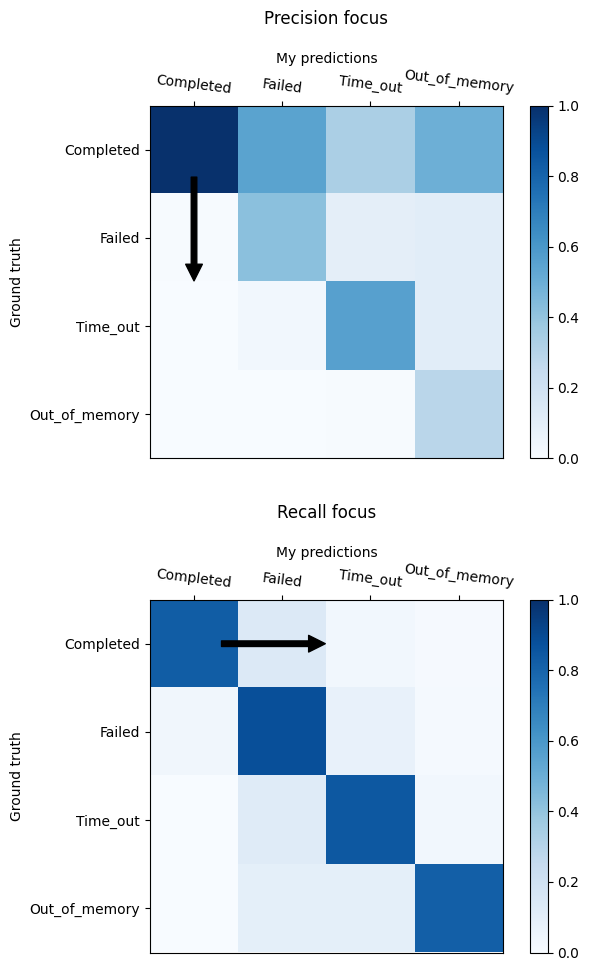

In [ ]:
plot_rec_prec(s.test_target, predictions)

Good recall, so my model is able to catch the true positive over all the possible positives (for class), but in precision we can catch an issue: <br/>
except for the completed class, precision for other classes is very bad, many false positive-->many misclassified completed jobs. <br/> We can state that it has a good bias toward the completed class (in the training set is not the major class, so a strange bias)... <br/>
**Thus my SVM model has been able to recognize the peculiarities that differentiate timeout, failed and out of memory jobs, but often he gets confused with Completed jobs.**

###XGBoost

This ML algorithm has many hyperparameters need to be optimized...so we'll use a surrogate ML model (gaussian process) to find the optimal values. <br/>
Particular mention for class weights: my model should works better with these ones (in xgboost for binary classification there is the parameter scale_pos_weight, instead if we deal with multiclass, we need to use the sample weight parameter...the approach will be the same, samples belonging to a certain class will have same weight). <br/>
<br/>
I've considered this approach for class weights: <br/>
- suggested by xgboost, num_negative_instances / num_pos_instances, but being my dataset heavy imbalanced, I will get very large weights for the minor classes, so this can result in a very large gradient (optimization algorithm becomes unstable). Thus I've added this param in the search space (range 0-4).

In [ ]:
import copy
class XGB:

  space = [Integer(8,40, name='max_depth'),  #at most 40 variables can interact together in a tree, since my variable are 30, some variable will be present more than once
           Real(0.01,0.5, name='gamma'), Real(1,5,name='lambda'),
           # log uniform:  same search space between different orders of magnitude (in gamma for me it's not necessary)
           Real(10**-3, 10**0, "log-uniform", name='eta'), Integer(1,2, name='min_child_weight'),
           Real(0.6, 1, name='colsample_bytree'), #random subsampling of features can be used to build a tree
           Integer(50, 1000, name='num_boost_round')]

  def __init__(self, train=(train_set, train_target), test=(test_set, test_target)):
    self.test_set, self.test_target = test
    self.train_set, self.val_set, self.train_target, self.val_target = train_test_split(train[0], train[1], train_size=0.9, random_state=41, stratify=train[1])
    self.history, self.eval_result = {}, {}
    self.leaves, self.splits, self.count = [], [], 0

  def __call__(self, *params):
    self.names = [self.space[x].name for x,_ in enumerate(self.space)] #name of each dimension in the space
    self.params = {self.names[x]:str(params[0][x]) for x in range(self.names.index('min_child_weight')+1)}
    self.weights = params[0][-4:] # last values are the class weights (in order we have completed, failed...)
    self.sample_weight = np.vectorize(lambda x: self.weights[int(x)])(self.train_target)
    self.num_boost_round = params[0][self.names.index('num_boost_round')] #num_boost_rounds need individual specification
    self.params.update({'objective' : 'multi:softmax', 'eval_metric':['mlogloss'], 'num_class':'4', 'seed':'41'})
    self.train = xgb.DMatrix(self.train_set, self.train_target, weight=self.sample_weight)
    self.val = xgb.DMatrix(self.val_set, self.val_target)
    self.test = xgb.DMatrix(self.test_set, self.test_target)
    self.early_stopping = xgb.callback.EarlyStopping(rounds=15, metric_name = 'f1_macro' , data_name='val')
    self.model = xgb.train(self.params, dtrain=self.train, evals=[(self.train, 'train'),(self.val, 'val')],
                           custom_metric=self.metric, callbacks=[self.early_stopping],
                           evals_result=self.eval_result, verbose_eval=False, num_boost_round=self.num_boost_round)
    self.best_score = np.round(self.model.best_score,6) # it works iff early stopping is performed
    self.history[self.best_score]=copy.deepcopy(self.eval_result) # i save history to check after possible overfitting...
    self.model.save_model('./'+ str(self.count) + 'model.json')
    self.count+=1
    # I wanna save also other infos as number of leaves and splits...
    self.trees_to_df = self.model.trees_to_dataframe()
    self.leaves.append(self.trees_to_df[self.trees_to_df['Feature']=='Leaf'].shape[0])
    self.splits.append(len(self.trees_to_df) - self.leaves[-1])
    print(f"f1_score: {self.best_score}... with iterations:{self.model.best_iteration}")
    return self.best_score # function value to be minimized

  def metric(self, predictions, data):
    self.label = data.get_label()
    self.predictions = predictions
    self.f1_macro = sum(f:=f1_score(self.label, self.predictions, average=None))/len(f)
    return 'f1_macro', - self.f1_macro


In [ ]:
#!mkdir xgb_model
os.mkdir('xgb_model', exist_ok=True)

mkdir: cannot create directory ‘xgb_model’: File exists


In [ ]:
%%time
xgb_model = XGB()
xgb_model.space = xgb_model.space + [Real(0,1, name='Weight') if x==0 else Real(1,4, name='Weight') for x in [0,1,2,3]]
res = gp_minimize(xgb_model, dimensions=xgb_model.space, n_initial_points=4, n_calls=7, acq_func='LCB', verbose=False, noise=None, random_state=41, kappa=1.9)

f1_score: -0.793642... with iterations:35
f1_score: -0.779656... with iterations:116
f1_score: -0.800645... with iterations:42
f1_score: -0.798171... with iterations:143
f1_score: -0.794592... with iterations:80
f1_score: -0.634122... with iterations:9
f1_score: -0.218065... with iterations:5
CPU times: user 8h 4min 33s, sys: 48.8 s, total: 8h 5min 22s
Wall time: 1h 8min 31s


This is the convergence plot, flat meaning no improvement


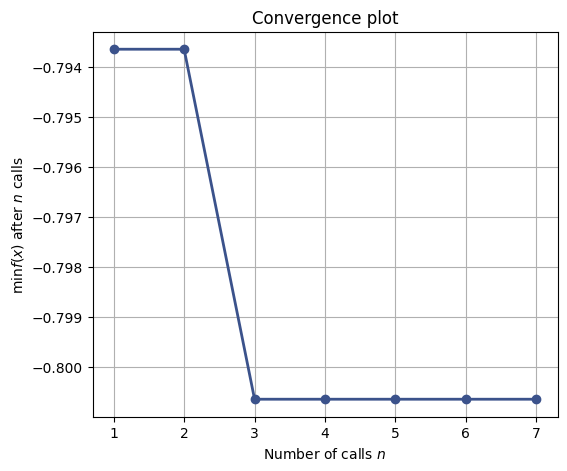

In [ ]:
print("This is the convergence plot, flat meaning no improvement")
plot_convergence(res)
plt.show()

In the choice of my hyperparams I wanna consider, not just the performance for the f1 metric, but also the performance from a complexity point of view. So now we consider all my models, to catch some insights from  xgboosting algorithm. <br/>
Remember, the complexity in this algorithm is given by the depth of trees and the number of trees. <br/>
A general complexity can be defined in this way: **num_trees x (2^max_depth)**

But from this plot we can view, that the complexity equation is not respected and we are faced with a varied situation due to two regularization techniques: pruning and early_stopping. <br/>
Now we plot the complexity defined by inner nodes (splits)

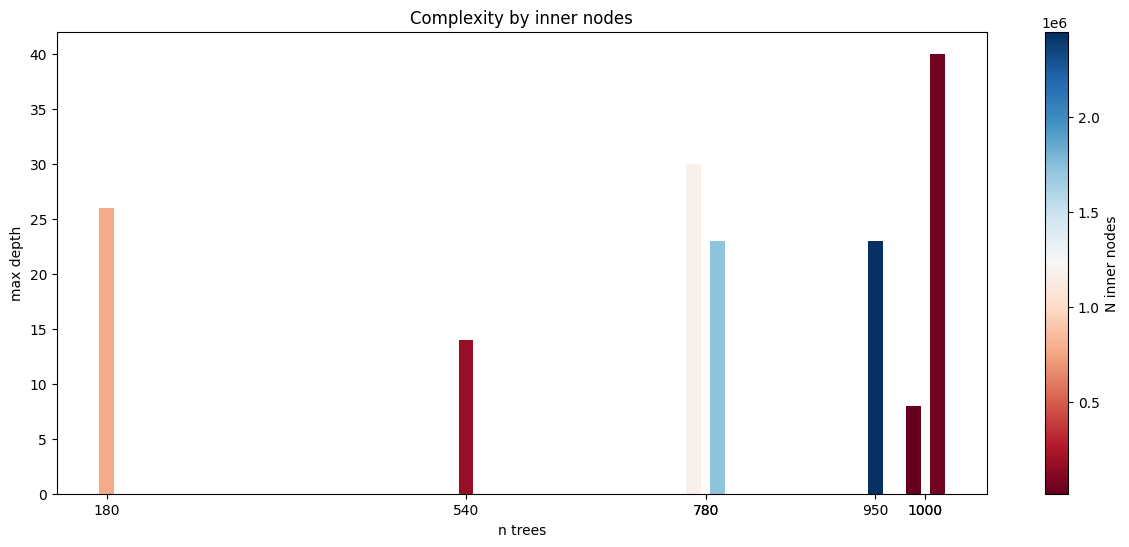

In [ ]:
from matplotlib.colors import Normalize
plt.figure(figsize=(15,6))
catch = lambda x: [y[xgb_model.names.index(x)] for y in res.x_iters]
num_boost_round, max_depth = catch('num_boost_round'), catch('max_depth')
normalization = plt.Normalize(min(xgb_model.splits), max(xgb_model.splits))
norm_splits = normalization(xgb_model.splits)
colormap='RdBu'
#approximate to multiple of 10 (more understandable plot)
num_boost_round_approx = list(map(lambda x: np.round(x/10)*10, num_boost_round))
# we can have duplicates in xaxis->num_boost_round so we wanna manage this situation to plot understandable bars in proximity of same x
num_boost_round_zip = [(y,num_boost_round_approx.count(y)) for x,y in enumerate(num_boost_round_approx) if y not in num_boost_round_approx[:x]]
#ugly code but necessary
count, libre = 0, 0
for x in num_boost_round_zip:
    if x[1]>1:
        for z in range(x[1]):
            plt.bar(x[0] - 12 + 12*libre, max_depth[count], width=15, color=plt.cm.get_cmap(colormap)(norm_splits[count]))
            count+=1
            libre+=2
    else:
        plt.bar(x[0], max_depth[count], width=15, color=plt.cm.get_cmap(colormap)(norm_splits[count]))
        count+=1
    libre=0

cbar=plt.colorbar(plt.cm.ScalarMappable(cmap=colormap, norm=normalization))
cbar.set_label('N inner nodes')
plt.xlabel('n trees')
plt.ylabel('max depth')
plt.xticks(num_boost_round_approx)
plt.title('Complexity by inner nodes')
plt.show()

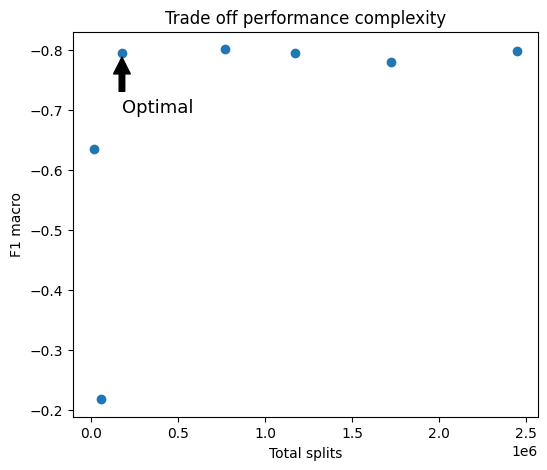

I have obtained 0.80 with these hyperparameters: max_depth:14, gamma:0.4461693284216107, lambda:2.817265811154313, eta:0.2694037004715481, min_child_weight:2, colsample_bytree:0.9633610205702434, num_boost_round:541, Weight:0.8926882153401166, Weight:3.483153786509696, Weight:1.0, Weight:1.759765855249579


In [ ]:
# trade off performance complexity
scores=list(xgb_model.history.keys())
norm_splits = np.asarray(xgb_model.splits)/max(xgb_model.splits)
optimal_score, s = scores[m:=np.argmin(list(norm_splits[x]+y for x,y in enumerate(scores)))], xgb_model.splits[m]
plt.scatter(x=xgb_model.splits, y=scores)
plt.gca().invert_yaxis()
plt.ylabel('F1 macro')
plt.xlabel('Total splits')
plt.title('Trade off performance complexity')
plt.annotate('Optimal', fontsize=13, xy=(s, np.round(optimal_score,3)),
             xytext=(s,np.round(optimal_score,3)+0.1 ), arrowprops=dict(facecolor='black', shrink=0.1))
plt.show()
best_params = res.x_iters[m] # best parameters
best_params_str = list(map(str, best_params)) #string
zipped_list = zip([x.name for x in xgb_model.space], best_params_str) #zippo nome e valore del parametro
print(f'I have obtained {-res.fun:.2f} with these hyperparameters: ' + ', '.join(':'.join(y) for y in zipped_list))

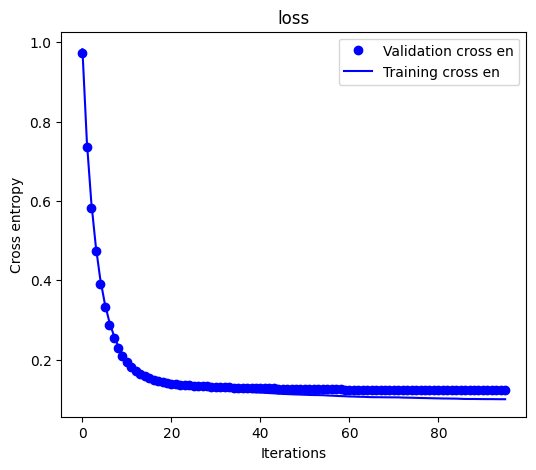

-0.800645

In [ ]:
iterations = len(xgb_model.history[optimal_score]['val']['mlogloss'])

plt.plot(range(iterations), xgb_model.history[optimal_score]['val']['mlogloss'], 'bo', label='Validation cross en')
plt.plot(range(iterations), xgb_model.history[optimal_score]['train']['mlogloss'], 'b', label='Training cross en')
plt.xlabel('Iterations')
plt.ylabel('Cross entropy')
plt.title('loss')
plt.legend()
plt.show()
res.fun

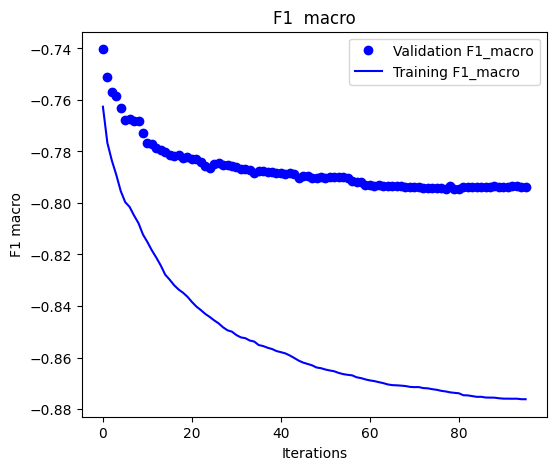

In [ ]:
plt.plot(range(iterations), xgb_model.history[optimal_score]['val']['f1_macro'], 'bo', label='Validation F1_macro')
plt.plot(range(iterations), xgb_model.history[optimal_score]['train']['f1_macro'], 'b', label='Training F1_macro')
plt.title('F1  macro')
plt.xlabel('Iterations')
plt.ylabel('F1 macro')
plt.legend()
plt.show()


There is overfitting for which regard the metric, it's quite comprehensible...this because the optimal 'regularizer paramters' are low.

Now we catch the optimal model and we verify it on the test set (we load our optimal model)

In [ ]:
my_model = xgb.Booster()
my_model.load_model(os.path.join('.', str(m)+'model.json'))

In [ ]:
predictions = my_model.predict(xgb_model.test)
precision = precision_score(xgb_model.test.get_label(), predictions, average=None)
recall = recall_score(xgb_model.test.get_label(), predictions, average=None)
f1 = f1_score(xgb_model.test.get_label(), predictions, average=None)
f1_macro = np.round(sum(f1) / len(f1), 2)
print(f"That's the F1 macroaverage obtained on the test set: {f1_macro}") # --> it's so bad
print("Other metrics: Precision:{}, Recall:{}, F1:{}".format(np.round(precision,2), np.round(recall,2), np.round(f1,2)))

That's the F1 macroaverage obtained on the test set: 0.8
Other metrics: Precision:[0.99 0.71 0.76 0.78], Recall:[0.96 0.91 0.63 0.71], F1:[0.97 0.79 0.69 0.74]


Now we wanna get some insights for which regards the features used. In particular we wanna know **weight** (the number of times a feature is used to split data across all trees) and **gain** (the average gain across all splits the feature is used in). We plot the 10 most important

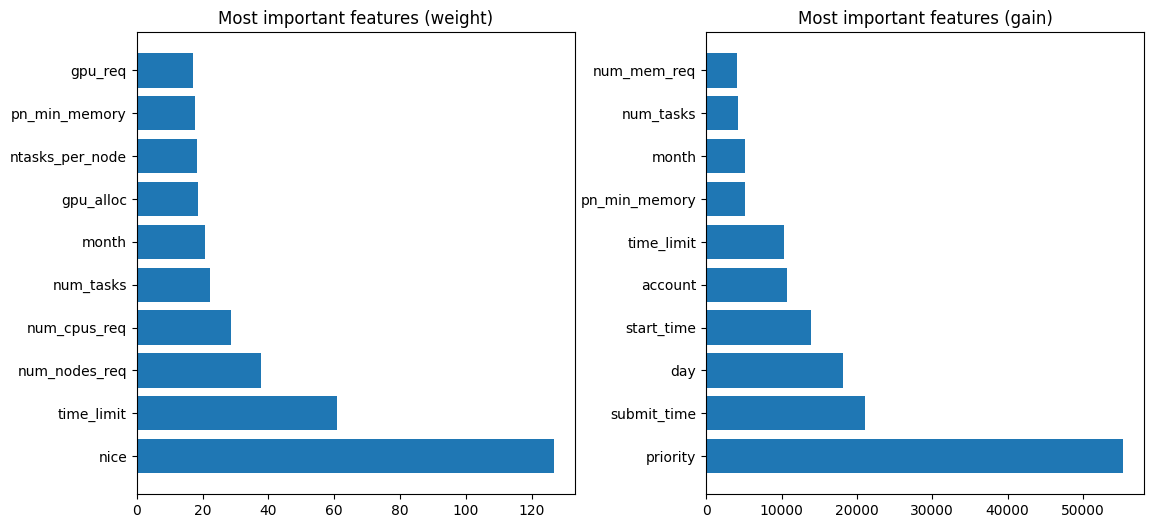

In [ ]:
plt.figure(figsize=(13,6))
order = lambda x: list(sorted(zip(x.keys(), x.values()), key=lambda x:x[1], reverse=True))[:10]
weight = order(my_model.get_score(importance_type='weight'))
gain = order(my_model.get_score(importance_type='gain'))
plt.subplot(1,2,1)
plt.barh([x[0] for x in gain], [x[1] for x in gain])
plt.title('Most important features (weight)')
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,2)
plt.barh([x[0] for x in weight], [x[1] for x in weight])
plt.title('Most important features (gain)')
plt.show()

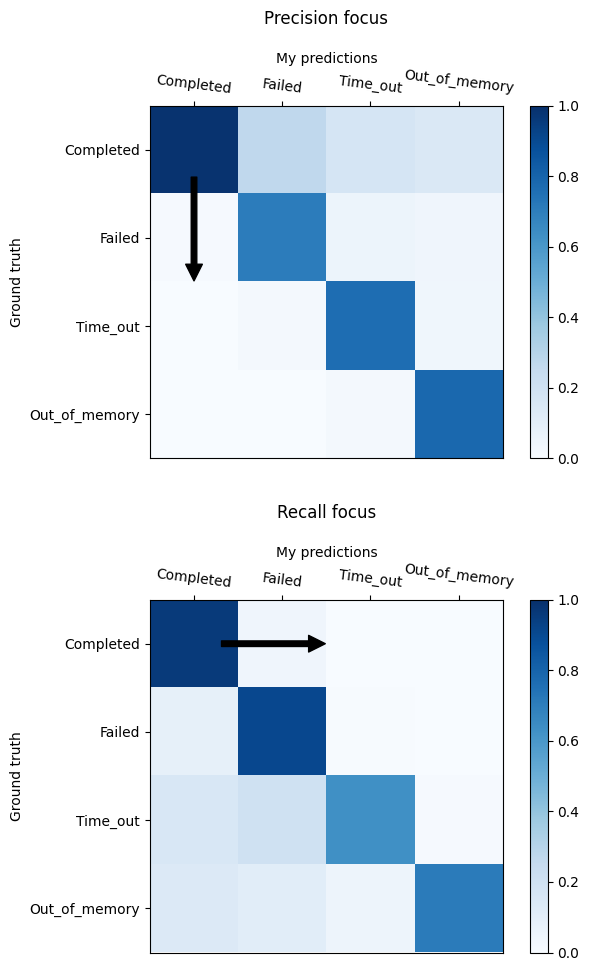

In [ ]:
plot_rec_prec(xgb_model.test.get_label(), predictions)

In Recall plot we can catch a very good recall for Failed and Completed classes --> no jobs of this kind of category is missed. <br/> Instead for Timeout and Out_of_memory, we have some 'missing', especially many misclassified Timeout, flagged as Failed. <br/>
For which regard Precision, it is so good for Completed jobs... A little bit less for the other classes: we have Completed jobs misclassified in pretty equal distribution between the three classes.

I can get some insight, visualizing a tree (we have one tree for each iteration...)

In [ ]:
# too depth, bad plot
# !pip install graphviz
# node_stats = new_model.get_score(importance_type='total_gain')
# xgb.plot_tree(new_model, num_tree=1) #we get the first tree
# plt.show()

- Each **node** is represented by the variable and the threshold for splitting the observation.
- Each **branch** either says yes or no (binary) -> if the value of that observation for this feature is above the threshold or not.
- **Leaf** tell us the output value for each leaf.



### Neural model
Now we are going to apply:
- a vanilla classification neural model <br/>
- with class weights <br/>
- with focal loss (not multiclass cross entropy) <br/>
- upsampling in train set <br/>

Obviously last three applications are used to deal with the imbalanced dataset

In [288]:
class F1_macro(keras.callbacks.Callback):

  def __init__(self, val_set, val_target, patience=15, bin=False):
    self.val_set = val_set
    self.val_target = val_target if bin else np.argmax(val_target, axis=1)
    self.patience = patience
    self.bin = bin

  def on_train_begin(self, logs=None):
    self.val_f1 = []
    self.wait, self.best = 0,0

  def on_epoch_end(self, epoch, logs=None):
    if epoch % 100 == 0: print()
    print('.', end='')
    self.val_predictions, self.f1_score = self.binary(self.model.predict(self.val_set, verbose=0)) if self.bin else self.multiclass(self.model.predict(self.val_set, verbose=0))
    self.val_f1.append(self.f1_score)
    if self.f1_score < self.best: # early stopping implementation...with restore best weights
      self.best = self.f1_score
      self.wait = 0
      self.best_weights = self.model.get_weights()
    else:
      self.wait+=1
      if self.wait>=self.patience:
        self.model.stop_training = True
        self.model.set_weights(self.best_weights)

  def multiclass(self, predictions):
    predictions = np.argmax(predictions, axis=1)
    f1 = - np.round(f1_score(self.val_target, predictions, average='macro'), 6)
    return predictions, f1

  def binary(self, predictions):
    predictions = np.round(predictions)
    f1 = - np.round(f1_score(self.val_target, predictions), 6)
    return predictions, f1

In [289]:
class NN_classification:

  def __init__(self, train=(train_set,train_target_cat), test=(test_set, test_target_cat), loss=None, upsampling=None):
    self.loss = loss if not loss else self.focal_loss
    self.train_set, self.train_target = train
    self.test_set, self.test_target = test
    self.train_set, self.val_set, self.train_target, self.val_target = train_test_split(self.train_set, self.train_target, train_size=0.9, random_state=41, stratify=train[1])
    self.stored_weights, self.total_history = {}, {}
    # search space for scikit-optimize.gp_minimize
    self.space = [Integer(2,15, name='layers'), Categorical([32,64], name='units'), Real(10**-6, 10**-4, 'log-uniform', name='L2'),
                  Real(10**-4, 10**-2, 'log-uniform', name='learning_rate')] #default is 0.001

    _ = self.upsampling() if upsampling else None

  def classification_model(self, hidden, output_shape=4, **other_params):
    # I am not going to use self.early_stopping but a custom early stopping defined in F1_macro class that will consider F1 metric and not loss
    #self.early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    model_in = keras.Input(shape=len(train_set.columns), dtype='float32')
    x = model_in
    for h in hidden:
      x = layers.Dense(h, activation='relu', **other_params)(x)
    model_out = layers.Dense(output_shape, activation='softmax')(x)
    self.model = keras.Model(model_in, model_out)

  def train_nn_model(self, learning_rate, **others):
    self.model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
                       loss='categorical_crossentropy' if not self.loss else self.loss)
    self.f1_macro = F1_macro(self.val_set, self.val_target)
    self.history = self.model.fit(self.train_set, self.train_target, callbacks=[self.f1_macro], epochs=1000,
                                                  verbose=0, batch_size=512, validation_data=(self.val_set, self.val_target), **others)

  def focal_loss(self, y_true, y_pred):
    # i decided to use keras backend...managing tensors with some tf operation is not too immediate
    # focal_loss(pt) = alpha * (1-pt)^gamma * -log(pt)
    gamma = self.params[0][self.names.index('gamma')]
    alpha = self.params[0][self.names.index('alpha')]
    epsilon = K.epsilon() # low constant value, to avoid division by zero error
    y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
    cross_entropy = -y_true * K.log(y_pred)
    weight = alpha * y_true * K.pow((1-y_pred), gamma)
    # compute focal loss
    focal_loss = weight * cross_entropy
    focal_loss = K.sum(focal_loss, axis=1) #sum for row, obviously we'll have one value, the others ones are zero
    return focal_loss

  def __call__(self, *params):
    self.params = params
    self.names = [self.space[x].name for x,_ in enumerate(self.space)]
    self.class_weights = None if 'class_weights' not in self.names else dict(enumerate(self.params[0][-4:]))
    _ = self.classification_model(hidden=[self.params[0][self.names.index('units')]]*self.params[0][self.names.index('layers')],
                                  kernel_regularizer=keras.regularizers.L2(self.params[0][self.names.index('L2')]))
    _ = self.train_nn_model(self.params[0][self.names.index('learning_rate')], class_weight=self.class_weights)
    self.best_score = np.min(self.f1_macro.val_f1) # I get the best metric value observed on validation data
    self.total_history[self.best_score] = copy.deepcopy(self.history.history)
    self.total_history[self.best_score]['f1_val'] = self.f1_macro.val_f1 # i save the history of my current model
    self.stored_weights[self.best_score] = self.model.get_weights()
    print()
    print(f"In this iteration, nn_model has obtained {self.best_score} in val_data")
    return self.best_score

  def upsampling(self):
    # we are upsampling minority classes --> with the techniques of duplication
    # I take just the first 200k otherwise too heavy from a computation point of view
    completed_set, completed_target = self.train_set[np.argmax(self.train_target, axis=1)==0][:2*10**5], self.train_target[np.argmax(self.train_target, axis=1)==0][:2*10**5]
    self.len = len(completed_target)
    failed_set, failed_target = self.partition(1)
    timeout_set, timeout_target = self.partition(2)
    out_of_memory_set, out_of_memory_target = self.partition(3)
    self.train_set = np.concatenate([completed_set, failed_set, timeout_set, out_of_memory_set], axis=0)
    self.train_target = np.concatenate([completed_target, failed_target, timeout_target, out_of_memory_target], axis=0)
    order = np.arange(len(self.train_target)) # we shuffle data
    np.random.shuffle(order)
    self.train_set = self.train_set[order]
    self.train_target = self.train_target[order]

  def partition(self, classs):
    indexes = lambda x: np.argmax(self.train_target, axis=1)==x
    sett, target = self.train_set.iloc[indexes(classs)], self.train_target[indexes(classs)]
    duplicates = np.random.choice(len(sett), self.len)
    return sett.iloc[duplicates], target[duplicates]

  def plot_history(self, score):
    self.epochs = len(self.total_history[score]['loss'])
    plt.plot(np.arange(self.epochs), self.total_history[score]['loss'], 'bo', label='loss')
    plt.plot(np.arange(self.epochs), self.total_history[score]['val_loss'], 'b', label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

  def predict(self, x, score):
    # retrieve the model thanks to the score
    self.classification_model(hidden=[x[self.names.index('units')]]*x[self.names.index('layers')],
                                  kernel_regularizer=keras.regularizers.L2(x[self.names.index('L2')]))
    self.model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=x[self.names.index('learning_rate')]),
                                  loss='categorical_crossentropy' if not self.loss else self.loss)
    self.model.set_weights(self.stored_weights[score])
    self.predictions = np.argmax(self.model.predict(self.test_set, verbose=0), axis=1)
    self.true = np.argmax(self.test_target, axis=1)
    self.precision = precision_score(self.true, self.predictions, average=None)
    self.recall = recall_score(self.true, self.predictions, average=None)
    self.f1 = f1_score(self.true, self.predictions, average=None)
    self.f1_macro = np.round(sum(self.f1) / len(self.f1), 2)
    print(f"That's the F1 macroaverage obtained on the test set: {self.f1_macro}")
    print("Other metrics: Precision:{}, Recall:{}, F1:{}".format(np.round(self.precision,2), np.round(self.recall,2), np.round(self.f1,2)))

In [ ]:
nn_model = NN_classification()
res_1 = gp_minimize(nn_model, dimensions=nn_model.space, n_initial_points=4, n_calls=6, acq_func='LCB', verbose=False, noise=None, random_state=45, kappa=1.8)


.......................................
In this iteration, nn_model has obtained -0.697233 in val_data

..................................................
In this iteration, nn_model has obtained -0.700034 in val_data

..............................
In this iteration, nn_model has obtained -0.644533 in val_data

...............................................
In this iteration, nn_model has obtained -0.717245 in val_data

.....................................................................
In this iteration, nn_model has obtained -0.724569 in val_data

........................................
In this iteration, nn_model has obtained -0.596099 in val_data


This is the convergence plot, flat meaning no improvement


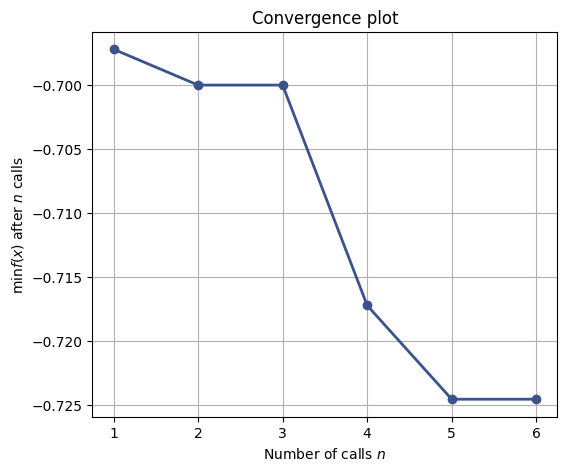

In [ ]:
print("This is the convergence plot, flat meaning no improvement")
plot_convergence(res_1)
plt.show()

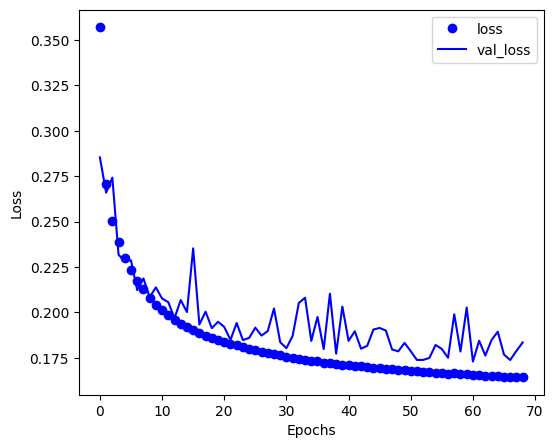

In [ ]:
nn_model.plot_history(res_1.fun)

We can view --> validation loss fluctuates too much. This is probably due to the fact I'm using a large network with little regularization. So my network has a lot of freedom for classifying training data, but only some of them are really good for generalization, others overfits too much.

In [ ]:
print('layers and units -->', res_1.x[:2])
print()
print('L2:',res_1.x[nn_model.names.index('L2')])

layers and units --> [15, 64]

L2: 4.067570648521376e-05


Yes, L2 it's small, for the next models I increase the upper bound.

In [ ]:
nn_model.predict(res_1.x, res_1.fun)

That's the F1 macroaverage obtained on the test set: 0.73
Other metrics: Precision:[0.96 0.78 0.66 0.66], Recall:[0.98 0.68 0.56 0.61], F1:[0.97 0.72 0.6  0.63]


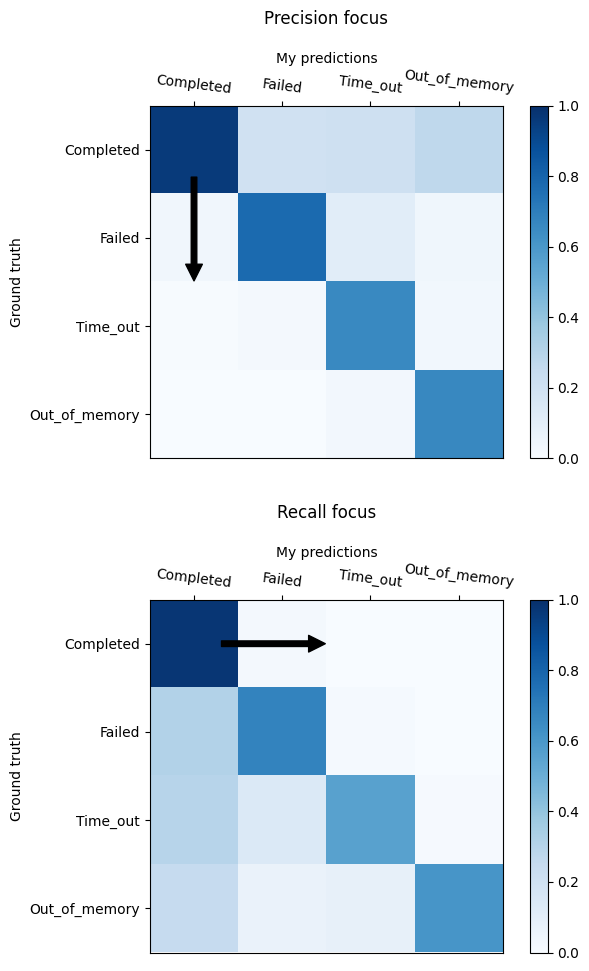

In [ ]:
plot_rec_prec(nn_model.true, nn_model.predictions)

Bad results, my model failed to capture the peculiarities of the three classes: FAILED, TIME OUT, OUT OF MEMORY, sadly there is a heavy bias toward the COMPLETED class...**We need some technique to deal with imbalancing**

#### Class weights

I am going to use a Real domain space, I'm delegating to my surrogate ML model, the choice of weights.<br/>
I've noticed it's better this kind of approach rather than using this formula for computing weights: 1/len(samples_class) * (total/num_classes), where scaling by total/4 helps keep the loss to a similar magnitude and the sum of the weights of all examples stays the same.

In [290]:
nn_model_weights = NN_classification()
nn_model_weights.space = nn_model_weights.space + [Real(0,1, name='class_weights') if x==0 else Real(1,8, name='class_weights') for x in [0,1,2,3]]
# we increase upper bound of L2
nn_model_weights.space[2] = Real(10**-6, 10**-3, 'log-uniform', name='L2')
res_2 = gp_minimize(nn_model_weights, dimensions=nn_model_weights.space, n_initial_points=4, n_calls=6, acq_func='LCB', verbose=False, noise=None, random_state=40, kappa=1.9)


...............................................................
In this iteration, nn_model has obtained -0.647803 in val_data

...........................................
In this iteration, nn_model has obtained -0.660333 in val_data

........................................
In this iteration, nn_model has obtained -0.667 in val_data

............................
In this iteration, nn_model has obtained -0.596739 in val_data

................................
In this iteration, nn_model has obtained -0.625448 in val_data

...........................
In this iteration, nn_model has obtained -0.635628 in val_data


This is the convergence plot, flat meaning no improvement


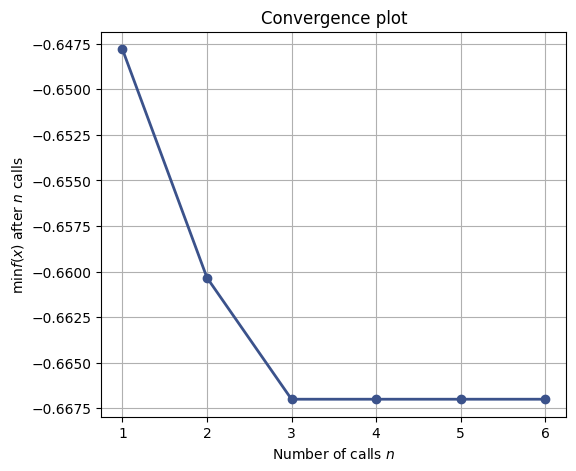

In [291]:
# plot convergence
print("This is the convergence plot, flat meaning no improvement")
plot_convergence(res_2)
plt.show()

In [302]:
print('These are the class weihgts:')
print(dict(zip(['Completed', 'Failed', 'Timeout', 'Out of memory'], res_2.x[-4:])))

These are the class weihgts:
{'Completed': 0.6538163382496468, 'Failed': 5.015689199332621, 'Timeout': 5.7615212254359855, 'Out of memory': 2.475221036622917}


In [293]:
# predict
nn_model_weights.predict(res_2.x, res_2.fun)

That's the F1 macroaverage obtained on the test set: 0.67
Other metrics: Precision:[0.98 0.52 0.56 0.52], Recall:[0.91 0.84 0.58 0.51], F1:[0.94 0.64 0.57 0.52]


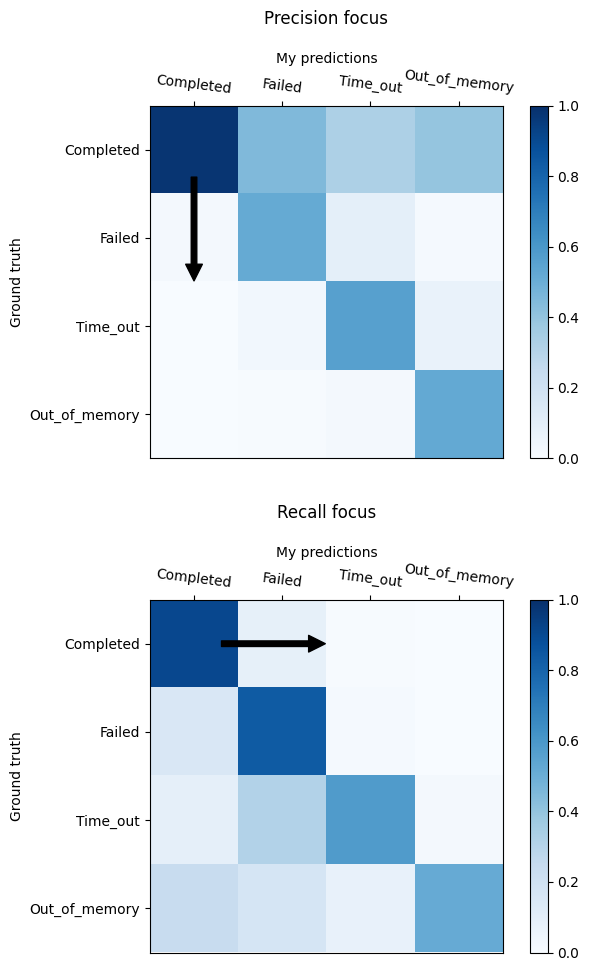

In [295]:
# plot precision recall
plot_rec_prec(nn_model_weights.true, nn_model_weights.predictions)

Bad result, in general class weihgts on F1_metric in imbalanced dataset performs better.

#### Focal loss

Focal_loss(pt) = - alpha * (1-pt)^lambda * log(pt) <br/>
**gamma** --> rate at which easy samples are down weighted and hard samples are up weighted, range(0,5) with 0 equal to cross entropy, so higher is the value, higher will be the discrepancy between easy samples and hard samples <br/>
**alpha** --> adjust the weights given to each class.

In [ ]:
nn_model_floss = NN_classification(loss=True)
nn_model_floss.space = nn_model_floss.space + [Real(0.1, 0.7, name='alpha'), Real(0, 5, name='gamma')]
res_3 = gp_minimize(nn_model_floss, dimensions=nn_model_floss.space, n_initial_points=4, n_calls=7, acq_func='LCB', verbose=False, noise=None, random_state=35, kappa=1.9)


......................................
In this iteration, nn_model has obtained -0.679165 in val_data

............................................
In this iteration, nn_model has obtained -0.563318 in val_data

.......................................................
In this iteration, nn_model has obtained -0.724058 in val_data

...............................
In this iteration, nn_model has obtained -0.637466 in val_data

............................................................................
In this iteration, nn_model has obtained -0.685345 in val_data

..............................................................................................
In this iteration, nn_model has obtained -0.603256 in val_data

.................................................................
In this iteration, nn_model has obtained -0.727183 in val_data


This is the convergence plot, flat meaning no improvement


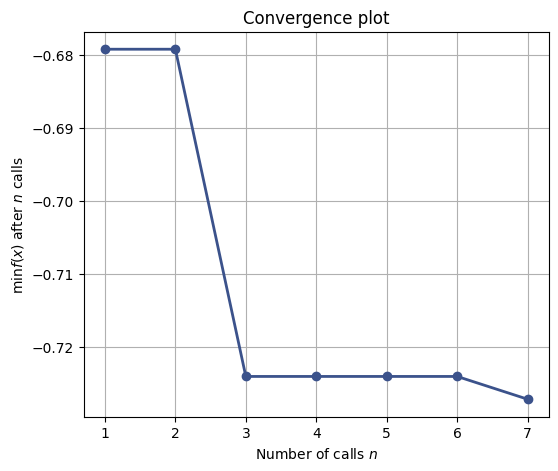

In [ ]:
# plot convergence
print("This is the convergence plot, flat meaning no improvement")
plot_convergence(res_3)
plt.show()

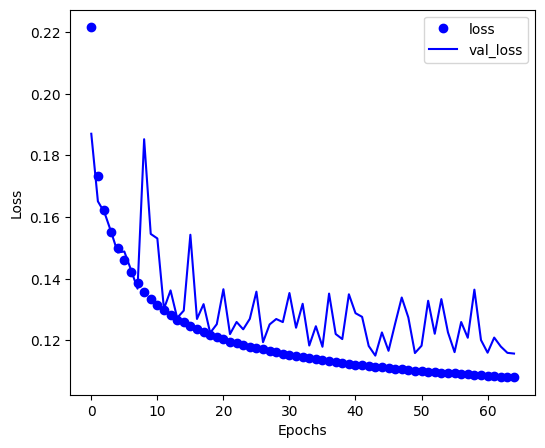

In [ ]:
# plot loss trend
nn_model_floss.plot_history(res_3.fun)

Anche qui:
We can view --> validation loss fluctuates too much. This is probably due to the fact I'm using a large network with little regularization. So my network has a lot of freedom for classifying training data, but only some of them are really good for generalization, others overfits too much.

In [ ]:
# predict
nn_model_floss.predict(res_3.x, res_3.fun)

That's the F1 macroaverage obtained on the test set: 0.72
Other metrics: Precision:[0.96 0.74 0.68 0.76], Recall:[0.97 0.7  0.54 0.5 ], F1:[0.97 0.72 0.6  0.61]


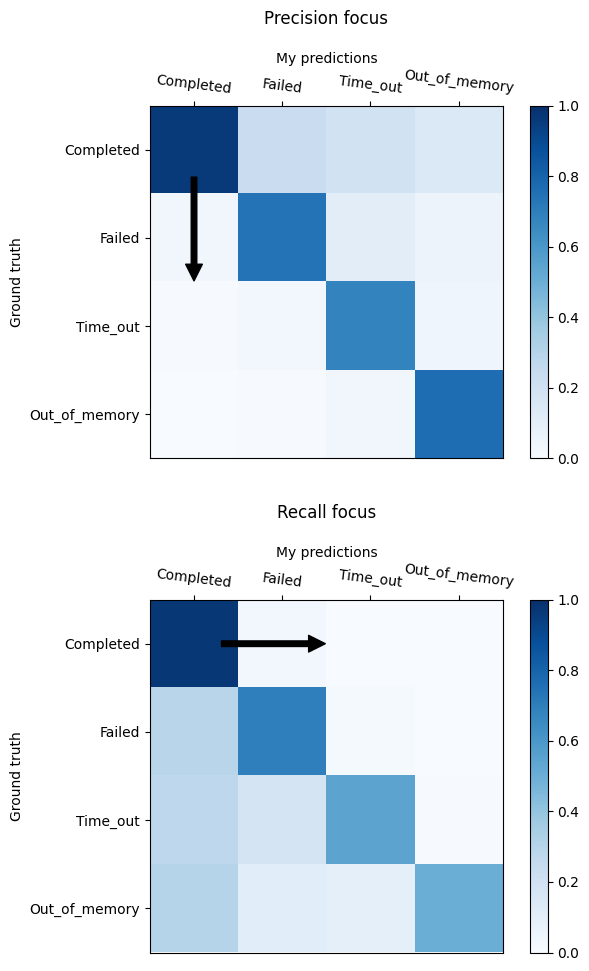

In [ ]:
# plot precision recall
plot_rec_prec(nn_model_floss.true, nn_model_floss.predictions)

My model has performed bad, in Precision we can view many completed jobs that are misclassified. <br/> In Recall instead we can view that non-completed classes have not managed to catch many correspondent jobs

#### Upsampling

I expect from this approach an introduction of bias or at least a reduction of valuable infos in the dataset. <br/>
Pros --> gentler technique w.r.t class weights, smoother gradient signal --> many minority samples in many batches instead of one sample with a big weight in one batch (gradient updated after each batch)

In [ ]:
nn_model_up = NN_classification(upsampling=True)
res_4 = gp_minimize(nn_model_up, dimensions=nn_model_up.space, n_initial_points=3, n_calls=5, acq_func='LCB', verbose=False, noise=None, random_state=41, kappa=1.8)


............................................
In this iteration, nn_model has obtained -0.562414 in val_data

......................................................
In this iteration, nn_model has obtained -0.607304 in val_data

.....................................................
In this iteration, nn_model has obtained -0.62741 in val_data

....................................................................................................
..................................................
In this iteration, nn_model has obtained -0.519917 in val_data

.................
In this iteration, nn_model has obtained -0.234023 in val_data


Being early stopping based on F1 score of validation data, we can encounter situation (especially here where distribution is so different between training and validation) where model'training stops immediately

This is the convergence plot, flat meaning no improvement


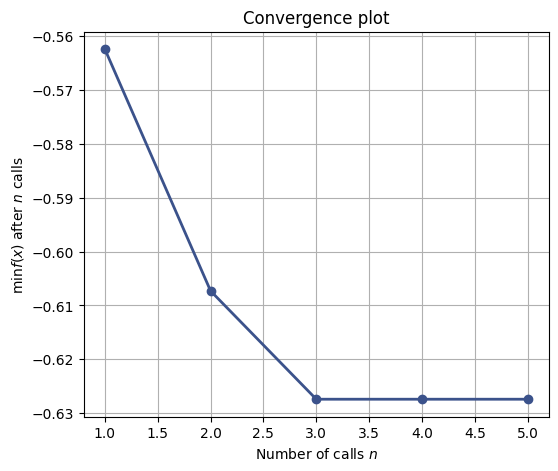

In [ ]:
# plot convergence
print("This is the convergence plot, flat meaning no improvement")
plot_convergence(res_4)
plt.show()

In [ ]:
nn_model_up.predict(res_4.x, res_4.fun)

That's the F1 macroaverage obtained on the test set: 0.63
Other metrics: Precision:[0.99 0.54 0.35 0.28], Recall:[0.89 0.87 0.78 0.9 ], F1:[0.94 0.67 0.48 0.42]


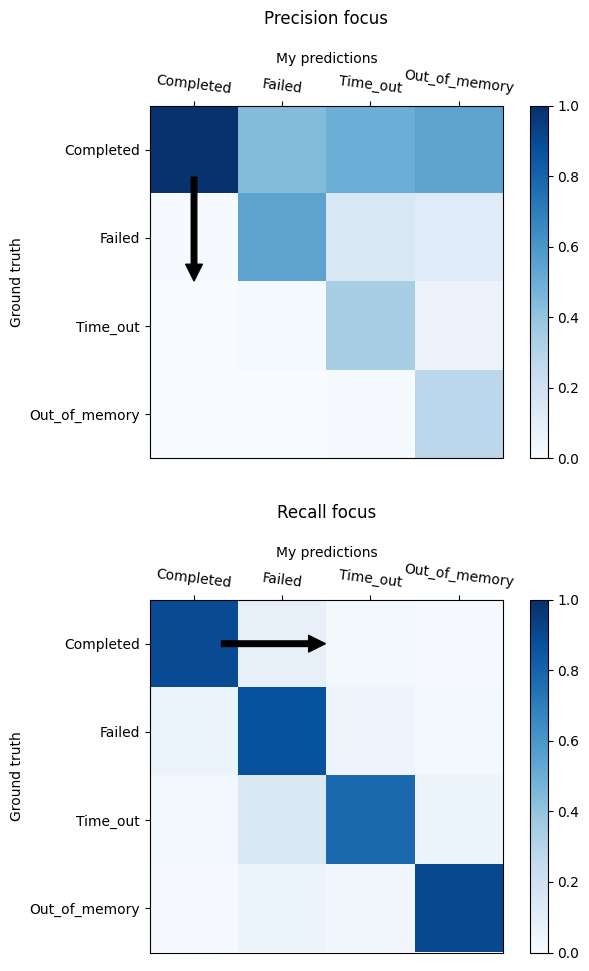

In [ ]:
# plot precision recall
plot_rec_prec(nn_model_up.true, nn_model_up.predictions)

From this approach we can catch two considerations: <br/>
- the valuable info --> 'many completed jobs' is lost, this can be viewed in the Precision performance, many completed jobs have been misclassified. <br/>
- Very good Recall, my model, with more samples for the three classes, has been able to catch all peculiarities.

## Binary classification

For the sake of curiosity I wanna apply binary classification, considering **Completed** and **Non Completed-jobs**. <br/>
I will optimize also the threshold with the AUC Precision Recall method. Good Result: **F1 score 84%** <br/>
Obviously I've considered my best model: **XGBoost**

In [161]:
class XGB_binary:

  space = [Integer(8,40, name='max_depth'),  #at most 40 variables can interact together in a tree, since my variable are 30, some variable will be present more than once
           Real(0.01,0.5, name='gamma'), Real(1,5,name='lambda'),
           # log uniform:  same search space between different orders of magnitude (in gamma for me it's not necessary)
           Real(10**-3, 10**0, "log-uniform", name='eta'), Integer(1,2, name='min_child_weight'),
           Real(0.6, 1, name='colsample_bytree'), #random subsampling of features can be used to build a tree
           Integer(50, 1000, name='num_boost_round')]

  def __init__(self, train=(train_set, train_target), test=(test_set, test_target)):
    self.test_set, self.test_target = test[0].copy(), test[1].copy()
    self.train_set, self.train_target = train[0].copy(), train[1].copy()
    ll = self.test_target != 0
    vv = self.train_target != 0
    self.test_target[ll] = 1.
    self.train_target[vv] = 1.
    self.train_set, self.val_set, self.train_target, self.val_target = train_test_split(self.train_set, self.train_target, train_size=0.9, random_state=41, stratify=self.train_target)
    self.history, self.eval_result = {}, {}
    self.leaves, self.splits, self.count = [], [], 0

  def __call__(self, *params):
    self.names = [self.space[x].name for x,_ in enumerate(self.space)] #name of each dimension in the space
    self.params = {self.names[x]:str(params[0][x]) for x in range(self.names.index('min_child_weight')+1)}
    self.weights = params[0][-2:] # last values are the class weights (in order we have completed, failed...)
    self.sample_weight = np.vectorize(lambda x: self.weights[int(x)])(self.train_target)
    self.num_boost_round = params[0][self.names.index('num_boost_round')] #num_boost_rounds need individual specification
    self.params.update({'objective' : 'binary:logistic', 'eval_metric':['logloss'], 'num_class':'1', 'seed':'41'})
    self.train = xgb.DMatrix(self.train_set, self.train_target, weight=self.sample_weight)
    self.val = xgb.DMatrix(self.val_set, self.val_target)
    self.test = xgb.DMatrix(self.test_set, self.test_target)
    self.early_stopping = xgb.callback.EarlyStopping(rounds=15, metric_name = 'f1' , data_name='val')
    self.model = xgb.train(self.params, dtrain=self.train, evals=[(self.train, 'train'),(self.val, 'val')],
                           custom_metric=self.metric, callbacks=[self.early_stopping],
                           evals_result=self.eval_result, verbose_eval=False, num_boost_round=self.num_boost_round)
    self.best_score = np.round(self.model.best_score,6) # it works iff early stopping is performed
    self.history[self.best_score]=copy.deepcopy(self.eval_result) # i save history to check after possible overfitting...
    self.model.save_model('./'+ 'binary' + str(self.count) + 'model.json')
    self.count+=1
    # I wanna save also other infos as number of leaves and splits...
    self.trees_to_df = self.model.trees_to_dataframe()
    self.leaves.append(self.trees_to_df[self.trees_to_df['Feature']=='Leaf'].shape[0])
    self.splits.append(len(self.trees_to_df) - self.leaves[-1])
    print(f"f1_score: {self.best_score}... with iterations:{self.model.best_iteration}")
    return self.best_score # function value to be minimized

  def metric(self, predictions, data):
    self.label = data.get_label()
    self.predictions = np.round(predictions)
    self.f1 = f1_score(self.label, self.predictions)
    return 'f1', - self.f1


In [163]:
%%time
xgb_model = XGB_binary()
xgb_model.space = xgb_model.space + [Real(0,1, name='Weight') if x==0 else Real(1,4, name='Weight') for x in [0,1]]
res = gp_minimize(xgb_model, dimensions=xgb_model.space, n_initial_points=4, n_calls=6, acq_func='LCB', verbose=False, noise=None, random_state=41, kappa=1.9)

f1_score: -0.806815... with iterations:143
f1_score: -0.703025... with iterations:276
f1_score: -0.829016... with iterations:89
f1_score: -0.818537... with iterations:69
f1_score: -0.795486... with iterations:96
f1_score: -0.810899... with iterations:33
CPU times: user 3h 46min 26s, sys: 15.8 s, total: 3h 46min 42s
Wall time: 36min 54s


In [164]:
from sklearn.metrics import precision_recall_curve

In [167]:
# we load the best model
my_model = xgb.Booster()
my_model.load_model(os.path.join('.', 'binary'+str(np.argmin(res.func_vals))+'model.json'))

In [181]:
predictions_prob = my_model.predict(xgb_model.test)
precision, recall, thresholds = precision_recall_curve(xgb_model.test.get_label(), predictions_prob)

In [182]:
# convert to f score
f1 = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
index = np.argmax(f1)
print('Best Threshold=%f, F1-Score=%.5f' % (thresholds[index], f1[index]))

Best Threshold=0.512361, F1-Score=0.83418


Best F1 obtained, I get the threshold that allow to get this result

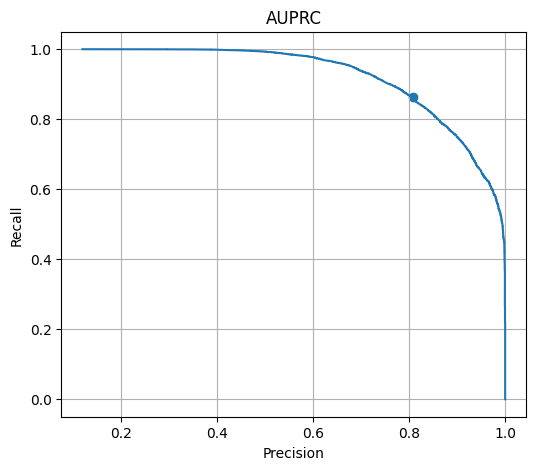

In [190]:
plt.plot(precision, recall)
plt.scatter(precision[index], recall[index])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid(True)
plt.title('AUPRC')
plt.show()

In general we can choose if we wanna maximize Precision or Recall, depends by costs...If we don't wanna miss never a Failed Jobs, then we wanna optimize Recall (0 false negative), in this case we'll generate also 'nuisance', because we'll have more False Positive

To verify the consistency, we try this threshold also into validation set and we obtain a better results of the previous ones obtained during training

In [172]:
predictions_prob = my_model.predict(xgb_model.val)
predictions_prob[predictions_prob>=thresholds[index]] = 1.
predictions_prob[predictions_prob<thresholds[index]] = 0.

In [173]:
# verify if the result obtained are better than the previous ones
f1_score_val = f1_score(xgb_model.val.get_label(), predictions_prob)
'Yes' if max([f1_score_val] + list(res.func_vals))==f1_score_val else 'No'

'Yes'

In [175]:
print(f1_score_val)

0.8294508785063192


## Consideration Probabilistic Neural Network

Until now in my analysis, we have omitted a proper quantification of the uncertainty in the predictions. Since there can be very different reasons on why a job can fails (some jobs have equal values for the features X but different job state), we try to consider the process generating the data with a stochastic meaning. We are dealing with an aleatoric uncertainty. \\
Until now using categorical cross entropy we intended the conditional distribution P(y|x,w) as a categorical distribution. Now using in turn of the softmax dense layer I will use OneHotCategorical probabilistic layer

In [393]:
import tensorflow_probability as tfp
import numpy
class NN_classification_probabilistic:

  def __init__(self, train=(train_set,train_target_cat), test=(test_set, test_target_cat), loss=None, upsampling=None):
    self.loss = loss if not loss else self.focal_loss
    self.train_set, self.train_target = train
    self.test_set, self.test_target = test


  def classification_model(self, hidden=[32,32,32,32], output_shape=4, **other_params):
    # I am not going to use self.early_stopping but a custom early stopping defined in F1_macro class that will consider F1 metric and not loss
    #self.early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    model_in = keras.Input(shape=len(train_set.columns), dtype='float32')
    x = model_in
    for h in hidden:
      x = layers.Dense(h, activation='relu', **other_params)(x)
    logits = layers.Dense(units=4)(x)
    model_out = tfp.layers.DistributionLambda(tfp.distributions.OneHotCategorical)(logits)
    self.model = keras.Model(model_in, model_out)

  def train_nn_model(self, **others):
    self.model.compile(optimizer=keras.optimizers.RMSprop(),
                       loss=lambda y_true, dist: -dist.log_prob(y_true))
    self.history = self.model.fit(self.train_set, self.train_target, epochs=50,
                                                  verbose=0, batch_size=512, **others)


In [401]:
nap = NN_classification_probabilistic()

In [395]:
nap.classification_model()
history = nap.train_nn_model()

In [396]:
y_pred = nap.model.predict(np.test_set).argmax(axis=1)

In [398]:
f1_score(nap.test_target.argmax(axis=1), y_pred, average=None)

array([0.94977164, 0.60938683, 0.39344262, 0.42158093])

Performance on macro F1 is not good, generally we cant consider it properly as a stochastic process although some jobs with equal features present different job state.